# Phase Separation in Binary Alloys: Cahn–Hilliard Simulation

This notebook investigates **phase separation** dynamics in binary alloys using the **Cahn–Hilliard equation**. The equation models how concentration fluctuations evolve over time due to competing effects of diffusion and interfacial energy.

The simulation is carried out in one spatial dimension using a semi-implicit time integration scheme with periodic boundary conditions.

---

## Goal

To simulate the temporal evolution of a binary alloy mixture governed by the Cahn–Hilliard equation, and understand how concentration domains form and coarsen over time.

---

## Approach

- Implement the **Cahn–Hilliard PDE** in 1D with periodic boundary conditions
- Discretize the system using finite differences in space
- Apply a **semi-implicit scheme** (backward Euler in linear terms, explicit in nonlinear terms)
- Visualize how small initial perturbations grow and drive **phase separation**
- Analyze how the **characteristic domain size** evolves over time

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")
# %matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fft2, ifft, ifft2, fftfreq, fftshift
import pandas as pd
import sympy as sy
from sympy import sin, exp, cos
from IPython.display import display, Markdown
from tqdm import tqdm
from matplotlib.animation import FuncAnimation,  PillowWriter

plt.rcParams.update({
     "font.family": "serif",             
    "mathtext.fontset": "cm",
    "font.size": 12,                
    "axes.titlesize": 16,           
    "axes.labelsize": 16,           
    "xtick.labelsize": 10,          
    "ytick.labelsize": 10,          
    "legend.fontsize": 10,          
    "lines.linewidth": 2,           
    "axes.grid": True,              
    "grid.linestyle": "--",         
    "grid.alpha": 0.6, 
})

### Oppgave 1.1

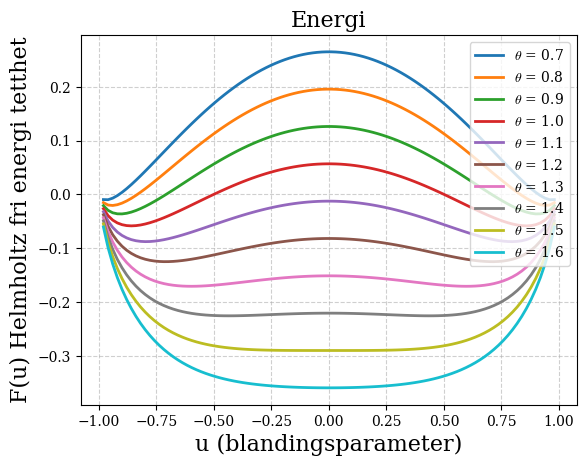

In [69]:
#logartihmic potential
temperatur_thetas = np.arange(0.7,1.7,0.1)
u = np.linspace(-1,1,100)
critical_temperature = 1.5

def log_potential(u,theta):
    l1 = (critical_temperature/2)*(1-u**2)
    l2 = (theta/2)*((1-u)*np.log((1-u)/2)+(1+u)*np.log((1+u)/2))
    return l1 + l2

for theta in temperatur_thetas:
    y_vals = log_potential(u,theta)
    plt.plot(u,y_vals, label = fr'$\theta$ = {np.round(theta,2)}')
    plt.legend(loc='upper right')

plt.title("Energi")
plt.xlabel("u (blandingsparameter)")
plt.ylabel("F(u) Helmholtz fri energi tetthet")
plt.show()

Ved lavere temperaturer enn kritisk temperatur $\theta_c$, ser vi at minimumspunktene er separert av en potensialbarriere. Dette beskriver en tilstand hvor energien minimeres dersom blandingen separeres i to forskjellige faser. For høyere temperaturer forsvinner potensialbarrieren, og vi får en konveks funksjon. Nå minimeres energien dersom vi har en perfekt blanding mellom de to fasene

### Oppgave 1.2

Vi skal vise at Cahn–Hilliard-likningen er invariant under transformasjonen  
$ u(x,t) \mapsto -u(x,t) $.  
Det vil si at hvis $ u(x,t) $ er en løsning, så er også $ -u(x,t) $ en løsning.

#### Cahn–Hilliard-ligningen

$\partial_t u - \nabla \cdot (M\nabla(f(u)-\kappa\Delta u)) = g$

#### Vil vise at -u(x,t) er en løsning dersom u(x,t) er en løsning.

Den deriverte er en lineær operator. Dette betyr at $\partial_t (-u) = -\partial_t u$. 

$\Delta u = \partial^2_x u + \partial^2_y u$, som er en operator som kun består av deriverte og addisjon, som også er lineære operatorer $\Rightarrow$ Laplace operatoren er lineær og $\Delta(-u) = -\Delta u$.

$\Delta^2 u = \Delta(\Delta(u))$, som er en operator som kun består av Laplace operatoren, som er lineær $\Rightarrow$ Den harmoniske operatoren er lineær og $\Delta^2(-u) = -\Delta^2 u$.

$f(u) = -\theta_c u + \frac{\theta}{2}\ln{\frac{1+u}{1-u}} \Rightarrow f(-u) = -\theta_c (-u) + \frac{\theta}{2}\ln{\frac{1+(-u)}{1-(-u)}} = \theta_c u + \frac{\theta}{2}\ln{\frac{1-u}{1+u}} = \theta_c u - \frac{\theta}{2}\ln{\frac{1+u}{1-u}} = -(-\theta_c u + \frac{\theta}{2}\ln{\frac{1+u}{1-u}}) \Rightarrow f(-u) = -f(u)$

Cahn-Hilliard-likningen består kun av operatorer og funksjoner som oppfyller at $ u(x,t) \mapsto -u(x,t) \Rightarrow $ Dersom $u(x,t)$ er en løsning er også $-u(x,t)$ også en løsning.

### Oppgave 1.3

Vi skal vise at systemets masse forblir konstant ved endring i tid. Altså vi vil vise at:

$\frac{d}{dt}\int_{\Omega} u(\mathbf{x},t) \,d\mathbf{x} = 0$

Det kan vises at: $\frac{d}{dt}\int_{\Omega} u(\mathbf{x},t) \,d\mathbf{x} = \int_{\Omega} \frac{d}{dt}  u(\mathbf{x},t) \,d\mathbf{x}$

Vi vet at $\partial_t u = M\Delta \mu \Rightarrow \int_{\Omega} M\Delta \mu \,d\mathbf{x} = 0$. Vi antar videre at $M = 1$

Ved bruk av divergensteoremet kan vi si at:

$\int_{\Omega} \Delta \mu \,d\mathbf{x} = \oint_{\partial \Omega} \nabla\mu \cdot \mathbf{\hat{N}} \,ds$

$\oint_{\partial \Omega} (\frac{\partial \mu}{\partial x},\frac{\partial \mu}{\partial y}) \cdot \hat{\mathbf{N}} \,ds = \int_{0}^{L_y} \nabla \mu(0, y) \cdot (0,-1) \,dy + \int_{0}^{L_x} \nabla \mu(x, 0) \cdot (-1,0) \,dx + \int_{0}^{L_y} \nabla \mu(L_x, y) \cdot (0,1) \,dy + \int_{0}^{L_x} \nabla \mu(x, L_y) \cdot (1,0) \,dx$

$\mu$ er periodisk, dette gir at $\mu(0, y) = \mu(L_x, y)$ og $\mu(x, 0) = \mu(x, L_y)$. Integralet forenkles derfor til:

$\int_{0}^{L_y} -\frac{\partial \mu}{dy} \,dy + \int_{0}^{L_x} -\frac{\partial \mu}{dx} \,dx + \int_{0}^{L_y} \frac{\partial \mu}{dy} \,dy + \int_{0}^{L_x} \frac{\partial \mu}{dy} \,dx = 0$. Herved vist.

$\frac{d}{dt}\int_{\Omega} u(\mathbf{x},t) \,d\mathbf{x} = 0 \Rightarrow \int_{\Omega} u(\mathbf{x},t) = konstant$. Massen er konstant over tid.

### Oppgave 2

In [70]:
def biharmonic_solver(X, Y, F, c, mean):
    x, y = X[:,0], Y[0,:]
    Nx, Ny = len(x), len(y)
    dx, dy = x[1] - x[0], y[1] - y[0]

    F_hat = fft2(F)
    kx = fftfreq(Nx, d=dx/ (2 * np.pi))
    ky = fftfreq(Ny, d=dy/ (2 * np.pi))
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2+KY**2
    KfourierSpace = (K2**2 + c)

    # Håndterer deling på null
    # Finn minste ikke-null verdi i K2
    K2_nonzero = K2[K2 > 0]
    k_min = np.sqrt(np.min(K2_nonzero))
    # Sjekk om c er null
    tol = 1e-14
    if c < tol * k_min**4:
        KfourierSpace[0,0] = 1

    u_hat = F_hat/KfourierSpace
    u_hat[0,0] = mean

    U = ifft2(u_hat).real

    return U

In [71]:
#parametere:
Nx1 = np.array([4,8,15,16,20,32])
Ny1 = 2*Nx1

k = np.arange(0,10)
Nx2 = 4+4*k
Ny2 =2*Nx2

Lx,Ly = 2 * np.pi, 4 * np.pi
mean = 0


In [72]:
#beregner høyreside: 
def manufacture_solution_biharmonic(u_string, c):
    x, y = sy.symbols('x y')
    u_symbolic = eval(u_string)

    laplace = lambda u: sy.diff(u, x, 2) + sy.diff(u, y, 2)
    
    #beregner dobbel laplace på funksjonen (laplace^2)
    firstLaplace = laplace(u_symbolic)
    biharmonic = laplace(firstLaplace)
    f_symbolic = biharmonic + c*u_symbolic
    f_symbolic = sy.simplify(f_symbolic)

    u = sy.lambdify((x, y), u_symbolic, modules='numpy')
    f = sy.lambdify((x, y), f_symbolic, modules='numpy')

    return u,f

In [73]:
u1_string = 'sin(8*(x-1))*cos(4*y)'
u1,f1 = manufacture_solution_biharmonic(u1_string, c = 1)

u2_string = 'exp(sin(x)**2+cos(2*y))'
u2,f2 = manufacture_solution_biharmonic(u2_string, c = 0)

In [74]:
#beregner feil og konsistensorden for metoden
def compute_errors(f,NX,NY,u,c):
    errors = []
    eocs = []
    for i in range(len(NX)):
        Lx = 2*np.pi
        Ly = 4*np.pi
        Nx = NX[i]
        Ny = NY[i]
        x = np.linspace(0,Lx,Nx, endpoint=False)
        y = np.linspace(0,Ly,Ny, endpoint=False)
        X,Y = np.meshgrid(x,y, indexing="ij")

        F = f(X,Y)
        U_ex = u(X,Y)
        U = biharmonic_solver(X, Y, F, c, mean)
        U += np.mean(U_ex)
        U_err = U - U_ex
        error = np.linalg.norm(U_err, np.inf)
        errors.append(error)

        if len(errors) > 1:
            h_now = Lx / NX[i]
            h_prev = Lx / NX[i-1]
            eoc = np.log(errors[-1] / errors[-2]) / np.log(h_now / h_prev)
            eocs.append(eoc)
        else:
            eocs.append("Not yet...")

    return errors,eocs
        
errors1, eocs1 = compute_errors(f1,Nx1,Ny1,u1,c=1)
errors2, eocs2 = compute_errors(f2,Nx2,Ny2,u2,c=0)

In [75]:
df1 = pd.DataFrame({
    'Nx': Nx1,
    'Ny': Ny1,
    'Feil': errors1,
    'EOC': eocs1
})


df2 = pd.DataFrame({
    'Nx': Nx2,
    'Ny': Ny2,
    'Feil': errors2,
    'EOC': eocs2
})

display(Markdown(r"### Resultater for $u_1$:"))
display(df1)
display(Markdown(r"### Resultater for $u_2$:"))
display(df2)

### Resultater for $u_1$:

,Nx,Ny,Feil,EOC
0,4,8,1.818989e-12,Not yet...
1,8,16,3.784353e+02,-47.563903
2,15,30,9.827684e+00,5.807813
3,16,32,7.863653e-14,502.942163
4,20,40,6.159517e-13,-9.224252
5,32,64,1.001514e-12,-1.034246


### Resultater for $u_2$:

,Nx,Ny,Feil,EOC
0,4,8,9.573099e+01,Not yet...
1,8,16,8.456927e+01,0.178852
2,12,24,1.123358e+01,4.978638
3,16,32,3.294907e-01,12.267412
4,20,40,1.254177e-02,14.647448
5,24,48,7.612873e-04,15.367403
6,28,56,4.102912e-05,18.947233
7,32,64,2.124529e-06,22.172552
8,36,72,9.783264e-08,26.133196
9,40,80,4.265664e-09,29.732775


- $f(x) = sin(8(x-1))cos(4y)$ har maskimalfrekvenser $f_x = \frac{8}{2\pi}$ og $f_y = \frac{4}{2\pi}$. For å unngå aliasing trenger vi en samplingsfrekvens som er minst 2 ganger så stor som maksimalfrekvensen. Samplingsfrekvensen, $f_{sampling} = \frac{N}{L}$. For å unngå aliasing trenger vi at $\frac{N_x}{L_x} \geq 2\frac{8}{2\pi}$ og $\frac{N_y}{L_y} \geq 2\frac{4}{2\pi}$. Med $L_x = 2\pi$ og $L_y = 4\pi$ får vi at $N_x \geq 16$ og $N_y \geq 16$, altså at vi trenger 16 eller mer samplingspunkter for å ikke få aliasing. Dette gjenspeiler seg i resultatene. For mindre enn 16 samplingspunkter fanges ikke de største frekvensene opp, og vi får store feil. Unntaksvis observerer vi for $N_x = 4$ tilsynelatende ekstremt lav feil (på størrelsesorden med maskinfeil), til tross for at samplingsfrekvensen egentlig er alt for lav. Dette skyldes at rutenettpunktene tilfeldgivis samsvarer med funksjonens minimumspunkter, noe som gir et kunstig inntrykk av høy nøyaktighet. For 16 samplingspunkter eller mer fanges alle frekvensene opp, og vi får ekstremt presise løsninger med minimiale feil. 

- $f(x) = exp(sin^2(x)+cos(2y))$ har maskimalfrekvenser $f_x = \frac{1}{2\pi}$ og $f_y = \frac{4}{2\pi}$. For å unngå aliasing trenger vi at $N_x \geq 2$. Ettersom vi kun tester funksjonen for fire eller mer samplingspunkter, får vi aldri aliasing. Jo fler samplingspunkter vi bruker jo større konvergensrate får vi.

In [76]:
def plot_solutions_all(Nx_list, Ny_list, Lx, Ly, f,u_exact, c):
    """
    Plotter (Exact, Numerical, Error) i hver sin kolonne for hver (Nx, Ny).
    Antall rader = len(Nx_list), antall kolonner = 3.
    """

    # Antall rader og kolonner i subplot-ruten
    nrows = len(Nx_list)
    ncols = 3

    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(12, 4*nrows),
                             subplot_kw={'projection': '3d'})

    # Hvis nrows == 1, blir axes en 1D-array på [3,], vi gjør den 2D for enkel looping.
    if nrows == 1:
        axes = np.array([axes])

    for i, (Nx, Ny) in enumerate(zip(Nx_list, Ny_list)):
        x = np.linspace(0, Lx, Nx, endpoint=False)
        y = np.linspace(0, Ly, Ny, endpoint=False)
        X, Y = np.meshgrid(x, y, indexing="ij")
        x_exact = np.linspace(0, Lx, 100, endpoint=False)
        y_exact = np.linspace(0, Ly, 100, endpoint=False)
        X_exact, Y_exact = np.meshgrid(x_exact, y_exact, indexing="ij")


        U = biharmonic_solver(X, Y, f(X, Y), c, mean=0.0)
        U += np.mean(u_exact(X, Y))

        error = np.abs(u_exact(X, Y) - U)


        # ============== Eksakt =================
        ax1 = axes[i, 0]
        ax1.plot_surface(X_exact, Y_exact, u_exact(X_exact, Y_exact),
                                 cmap='viridis', edgecolor='none')
        min = np.min(u_exact(X_exact, Y_exact))
        max = np.max(u_exact(X_exact, Y_exact))
        ax1.set_title(fr'Exact ($N_x={100}$, $N_y={200}$)')
        ax1.set_xlabel("x")
        ax1.set_ylabel("y")
        ax1.set_zlabel(r"$u(x,y,t)$")

        sm = plt.cm.ScalarMappable(cmap='viridis')
        sm.set_array([])  
        sm.set_clim(min, max)
        fig.colorbar(sm, ax=ax1,shrink=0.5, aspect=10, pad=0.2)

        # ============== Numerisk =============
        ax2 = axes[i, 1]
        ax2.plot_surface(X, Y, U,
                                 cmap='viridis', edgecolor='none')
        ax2.set_title(fr'Numerical ($N_x={Nx}$, $N_y={Ny}$)')
        #ax2.view_init(10, 309)
        min = np.min(U)
        max = np.max(U)

        sm = plt.cm.ScalarMappable(cmap='viridis')
        sm.set_array([])  
        sm.set_clim(min, max)
        fig.colorbar(sm, ax=ax2,shrink=0.5, aspect=10, pad=0.2)
        ax2.set_xlabel("x")
        ax2.set_ylabel("y")
        ax2.set_zlabel(r"$U$")
    

        # ============== feil =================
        ax3 = axes[i, 2]
        surf3 = ax3.plot_surface(X, Y, error,
                                 cmap='hot', edgecolor='none')
        ax3.set_title(f'Error (max={np.max(error):.2e})')
        fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10, pad=0.2)
        ax3.set_xlabel("x")
        ax3.set_ylabel("y")
        ax3.set_zlabel(r"$u(x,y,t)- U$")

    plt.tight_layout()
    plt.show()

### Løsning for $u_1$:

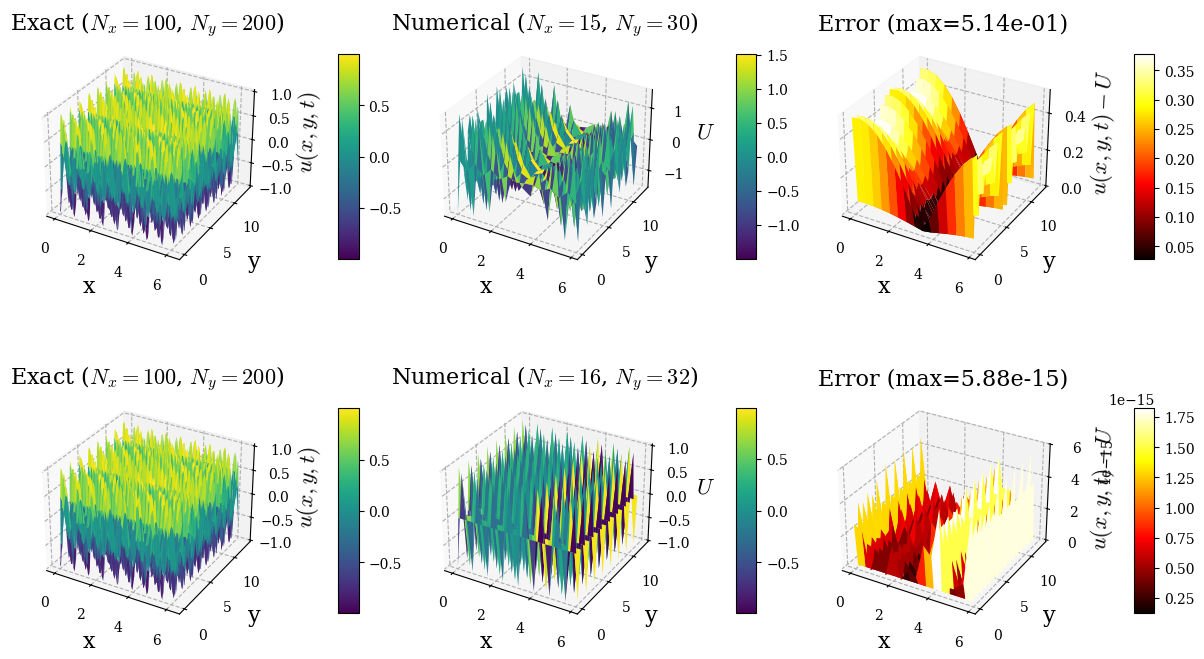

### Løsning for $u_2$:

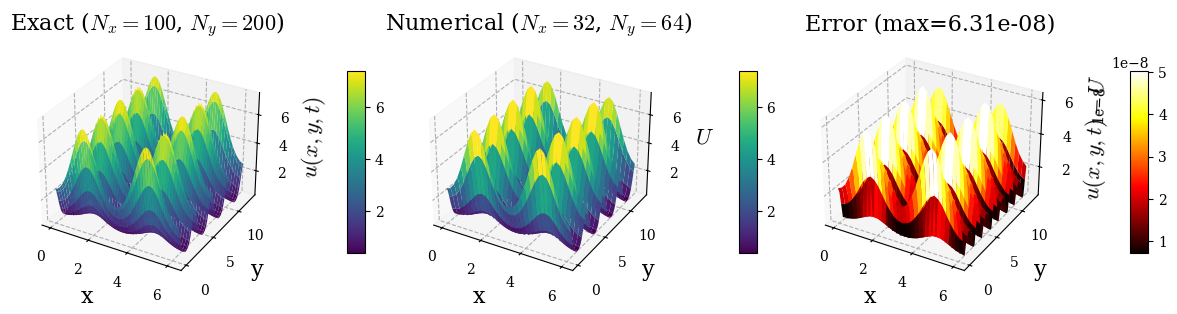

In [77]:
Nx_list = np.array([15, 16])
Ny_list = Nx_list*2
Lx,Ly = 2 * np.pi, 4 * np.pi
display(Markdown(r"### Løsning for $u_1$:"))
plot_solutions_all(Nx_list,Ny_list,Lx,Ly,f1,u1,c=1)

Nx_list = np.array([32])
Ny_list = 2*Nx_list
display(Markdown(r"### Løsning for $u_2$:"))
plot_solutions_all(Nx_list, Ny_list, Lx,Ly,f2, u2,c = 0)

Vi plotter den eksakte løsningen i et finere grid for å vise den eksakte løsningen bedre. I plottene ser vi at for $N_x = 15$ får vi aliasing effekten som er diskutert over og en relativt stor feil. For $N_x = 16$ får vi en løsning med mye mindre feil (uten aliasing). Den blir dog ikke like glatt som den eksakte løsningen men gir en god representasjon. Feilen blir beregnet i gridet vi faktisk evaluerer den numeriske løsningen i. Man kan se at begge de numeriske løsningene er gode representasjoner av den eksakte løsningen for $N_x = 16$ for $u_1$ og $N_x = 32$ for $u_2$.

## Oppgave 3 teoridel

### oppgave 3.1

Vi begynner med $\theta$-metoden; den er definert slik:

$
U^{n+1} = U^n + \tau \left( \theta F(t_{n+1}, U^{n+1}) + (1 - \theta) F(t_n, U^n) \right), \quad \text{for } n = 0, 1, 2, \dots, N - 1
$

Herifra kan vi definere $k_1$ og $k_2$:

$k_1 = F(t_n, U^n)$  
$k_2 = F(t_{n+1}, U^{n+1}) = F(t_n + \tau, U^n + \tau(\theta k_2 + (1-\theta)k_1))$ 

Vi kan merke oss at $k_1$ beregnes eksplisitt og at $k_2$ beregnes implisitt. Vi kan skrive:

$U^{n+1} = U^n + \tau \cdot (\theta k_2 + (1-\theta)k_1)$    

Fra dette kan vi utlede en generell butcher tabell ved å benytte at:

$
k_j := f\left(t_k + c_j \tau,\ y_k + \tau \sum_{l=1}^{s} a_{jl} k_l\right), \quad j = 1, \dots, s,
$  
  
$
y_{k+1} := y_k + \tau \sum_{j=1}^{s} b_j k_j
$

Dersom $\theta = 0$ vil den implisitte delen forsvinne. Da sitter vi igjen med en forward euler:

$U^{n+1} = U^{n} + \tau F(t_n, U^n)$

Denne har følgende butcher tabell:

$
\begin{array}{c|cc}
0 & 0 \\
\hline
  & 1
\end{array}
$

Dersom $\theta = 1$ vil den eksplisitte delen forsvinne. Da sitter vi igjen med en backward euler:

$U^{n+1} = U^{n} + \tau F(t_{n+1}, U^{n+1})$

Denne har følgende butcher tabell:

$
\begin{array}{c|cc}
1 & 1 \\
\hline
  & 1
\end{array}
$

Dersom $0 < \theta < 1$ forsvinner ingen ledd og butcher tabellen blir da i det generelle tilfellet slik:

$
\begin{array}{c|cc}
0 & 0 & 0 \\
1 & 1 - \theta & \theta \\
\hline
  & 1 - \theta & \theta
\end{array}
$

Fra dette observer vi en kjent Runge-Kutta metode dersom $\theta = \frac{1}{2}$, altså Crank-Nicholson metoden:

$
\begin{array}{c|cc}
0 & 0 & 0 \\
1 & \frac{1}{2} & \frac{1}{2} \\
\hline
  & \frac{1}{2} & \frac{1}{2}
\end{array}
$


**Konsistensorden for ulike $\theta$**   
*For å bestemme konsistensorden avhengig av theta benytter vi tabellen i forelesningsnotatene.*  
### Betingelser for konsistensorden

| $p$ | Betingelser |
|-----|------------|
| 1   | $\sum_{i=1}^{s} b_i = 1$ |
| 2   | $\sum_{i=1}^{s} b_i c_i = \frac{1}{2}$ |
| 3   | $\sum_{i=1}^{s} b_i c_i^2 = \frac{1}{3}$  <br> $\sum_{i=1}^{s} \sum_{j=1}^{s} b_i a_{ij} c_j = \frac{1}{6}$ |
| 4   | $\sum_{i=1}^{s} b_i c_i^3 = \frac{1}{4}$ <br> $\sum_{i=1}^{s} \sum_{j=1}^{s} b_i c_i a_{ij} c_j = \frac{1}{8}$ <br> $\sum_{i=1}^{s} \sum_{j=1}^{s} b_i a_{ij} c_j^2 = \frac{1}{12}$ <br> $\sum_{i=1}^{s} \sum_{j=1}^{s} \sum_{k=1}^{s} b_i a_{ij} a_{jk} c_k = \frac{1}{24}$ |   

Det første vi kan legge merke til er at uavhengig av theta vil alle metodene ha minst konsistensorden 1.  
Dette er fordi summen av $\sum_{i=1}^{2} b_i = 1 - \theta + \theta = 1$

In [78]:
theta = np.linspace(0,1,1000)
print("Sjekker noen θ-verdier for konsistensorden:")
print("-------------------------------------")
for i in range(len(theta)):
    c1 = 0
    c2 = 1
    a11 = 0
    a12 = 0
    b1 = 1 - theta[i]
    b2 = theta[i]
    a21 = 1- theta[i]
    a22 = theta[i]
    #check for p = 2:
    sum = b1*c1+b2*c2
    if sum < 0.5005 and sum > 0.499:
        print("Sjekker for p = 2:")
        print(f"p = 2 for θ = {theta[i]:.1f}")
        print("θ = 0.5 er dermed en θ-verdi som gir konsistensorden 2!")

Sjekker noen θ-verdier for konsistensorden:
-------------------------------------
Sjekker for p = 2:
p = 2 for θ = 0.5
θ = 0.5 er dermed en θ-verdi som gir konsistensorden 2!


Kodesnutten itererer gjennom noen theta verdier og tester for konsistensorden 2. 
Det er kun $\theta = \frac{1}{2}$ som gir konsistensorden 2. Dette er Crank-Nicholson metoden, som kjent har konsistensorden 2.

###  Konklusjon:

- For $ \theta = 0 $: Forward Euler → orden 1
- For $ \theta = 1 $: Backward Euler → orden 1
- For $ \theta = \frac{1}{2} $: Crank–Nicolson → orden 2
- For andre verdier av $\theta $ er det en 1. ordens metode

### Oppgave 3.2

Vi ønsker å finne en stabilitetsfunksjon, $r_{\theta}(z)$, slik at vi kan skrive:

$U^{n+1} = r(z) U^n$ der $z = \lambda\tau$

Som lineær testfunksjon bruker vi:

$\partial_t U^n = \lambda U^n = F(t_n,U^n)$ 

$\theta$-metoden:

$U^{n+1} = U^n + \tau \left( \theta F(t_{n+1}, U^{n+1}) + (1 - \theta) F(t_n, U^n) \right)$ 

Kan skrives:

$U^{n+1} = U^n + \tau ((\theta \lambda \cdot U^{n+1})  + (1 - \theta) \lambda \cdot U^n )$

$\Rightarrow \frac{U^{n+1}}{U^n} = \frac{1 + \tau \lambda - \tau \theta \lambda}{1 - \tau \theta \lambda} \Rightarrow r(z) = \frac{1 + \tau \lambda - \tau \theta \lambda}{1 - \tau \theta \lambda}$

Dette blir stabilitetsfunksjonen $r_{\theta}(z)$ som vi nå skriver som:  

$r_{\theta}(z) = 1 + \frac{z}{1-z \theta}$  

Metoden er A-stabil dersom $|r(z)| \leq 1 \  \forall \  Re(z) \leq 0$

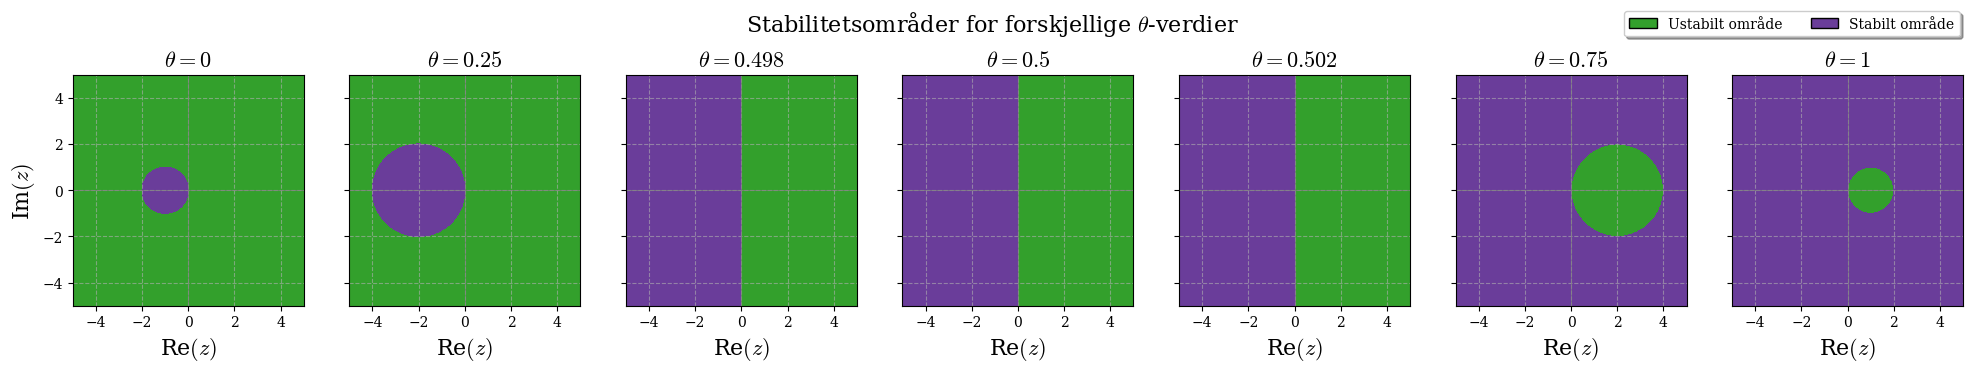

In [79]:
a = np.linspace(-5, 5, 1000)
b = np.linspace(-5, 5, 1000)
A, B = np.meshgrid(a, b)
Z = A + B * 1j

# Stabilitetsfunksjonen
def Rz(Z, theta):
    R = 1 + Z / (1 - Z * theta)
    return np.abs(R)

fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)

# Theta-verdier
theta_vals = [0, 0.25, 0.498, 0.5, 0.502,0.75,1]

# Plot hver region på sin egen aksis
for ax, theta in zip(axes, theta_vals):
    ax.contourf(A, B, Rz(Z, theta) <= 1, cmap='Paired', levels=1)
    ax.set_title(rf"$\theta = {theta}$")
    ax.set_xlabel("Re$(z)$")
    ax.axhline(0, color='gray', lw=0.5)
    ax.axvline(0, color='gray', lw=0.5)
    ax.set_aspect("equal")

axes[0].set_ylabel("Im$(z)$")
fig.suptitle("Stabilitetsområder for forskjellige $\\theta$-verdier", fontsize=16)
legend_elements = [
    Patch(facecolor='#33a02c', edgecolor='k', label='Ustabilt område'),
    Patch(facecolor='#6a3d9a', edgecolor='k', label='Stabilt område')
]
fig.legend(handles=legend_elements, loc = 'upper center', bbox_to_anchor=(0.9, 0.99),
          fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()


Hele det venstre halvplanet, det vil si mengden {$z \in \mathbb{C}, \text{Re}(z) \leq 0$}, ser ut til å være en del av stabilitetsområdet for $\theta \geq 0.5$. Dette kan indikere at $\theta$-metoden er A-stabil for $\theta \geq 0.5$.

### Oppgave 3.3

Stabile områder gis for:
  
$|r_{\theta}(z)| \leq 1$

$|r_{\theta}(z)| = |\frac{U^{n+1}}{U^n}| = |1 + \frac{z}{1-z \theta}|$

Grensen for stabilitetsregionen er dermed gitt ved:  

$
\partial S_\theta = \left\{ z \in \mathbb{C} \;:\; |r_\theta(z)| = 1 \right\}
$

Fra dette kan vi prøve å forenkle uttrykket:

Vi starter med:   

$|r_\theta(z)| = |1 + \frac{Z}{1-z \theta}|=  |\frac{1+z(1-\theta)}{1-z \theta}| = 1$

For komplekse brøker gjelder:

$|\frac{a}{b}| = \frac{|a|}{|b|}$

$|\frac{1+z(1-\theta)}{1-z \theta}| = 1 \iff |1+z(1-\theta)| = |1-z \theta|$  

Kvadrerer begge sidene:  

$|1+z(1-\theta)|^2 = |1-z \theta|^2$ 

Nå kan vi sette inn $x$ og $iy$ for z og oppnår:  

$|1+(x+iy)(1-\theta)|^2 = |1-(x+iy) \theta|^2$ 

Samtidig benytter vi at for et komplekst tall at:

$|w|^2 = x^2 + y^2$  

Da kan vi skrive om likninga over til:  

$[1+x(1-\theta)]^2 + [y(1-\theta)]^2 = [1-x \theta]^2+[y \theta]^2$

Nå kan vi utvide og forenkle uttrykk:

$(1 + 2x(1 - \theta) + x^2(1- \theta)^2) + y^2(1- \theta)^2 = (1 - 2x \theta + x^2 \theta^2) + y^2 \theta^2$

Vi oppnår da:

$2x + (1 - 2\theta)(x^2+y^2) = 0$

Dette likner på likningen for en sirkel og vi innfører en ny variabel $\beta$ for å forenkle og fullfører kvadratet:  

$\beta = 1 - 2\theta$

$\frac{2x}{\beta} + x^2 + y^2 = 0$

Vi får sirkellikninga:  

$(x+\frac{1}{{\beta}})^2 + y^2 = \frac{1}{\beta^2}$

Vi kan gjøre noen generelle observasjoner her:  
- Sentrum i sirkelen ligger i: $(-\frac{1}{\beta} = - \frac{1}{1 - 2\theta}, 0)$
- Radiusen til sirkelen der metoden er stabil er $r = \frac{1}{|\beta|} = \frac{1}{|1 - 2\theta|}$
- $\lim_{\theta \to \frac{1}{2}^{-}} \frac{1}{|1 - 2\theta|} = \infty$

### Konklusjon:

For $\theta = \frac{1}{2}$ går stabilitetsregionens radius mot uendelig, dette betyr at hele venstre halvplan er A-stabilt, altså $\theta > \frac{1}{2} \Rarr$ A-stabilt!

For  $\theta < \frac{1}{2}$ er stabilitetsregionen en sirkel som ikke dekker hele halvplanet, dermed er den stabil i enkelte regioner, men ikke fullstendig A-stabil.

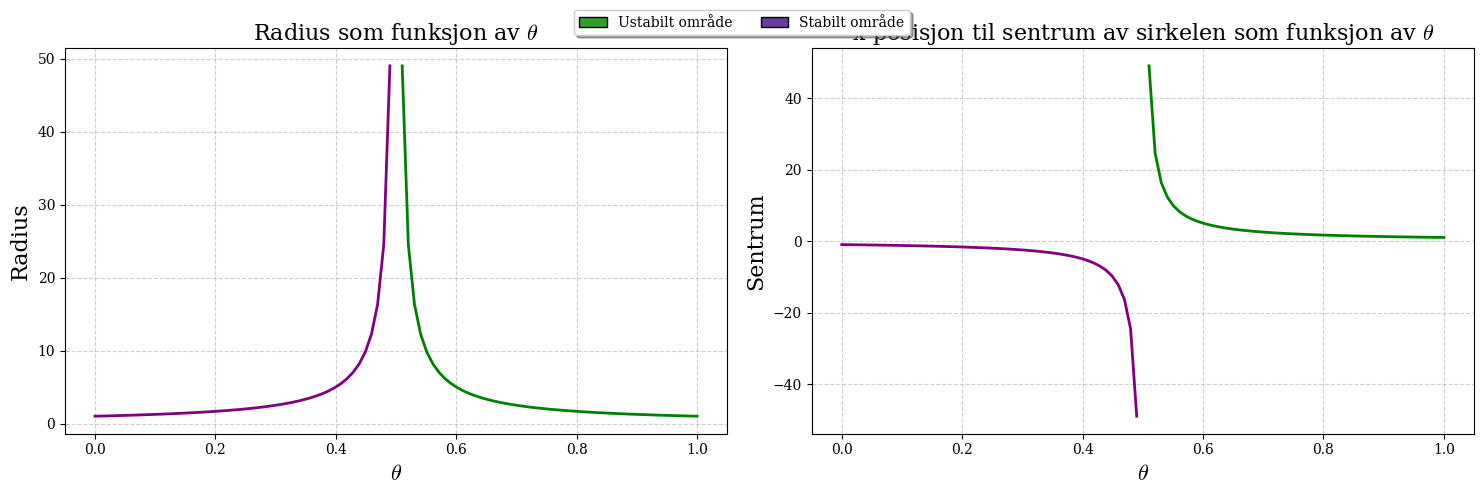

In [80]:
theta1 = np.linspace(0,0.5,50)
theta2 = np.linspace(0.5,1,50)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(theta1, 1 / (1 - 2 * theta1), color = "purple")
ax[0].plot(theta2, -1 / (1 - 2 * theta2), color = "green")
ax[0].set_title(r"Radius som funksjon av $\theta$")
ax[0].set_xlabel(r"$\theta$")
ax[0].set_ylabel(r"Radius")

ax[1].plot(theta1, -1 / (1 - 2 * theta1), color = "purple")
ax[1].plot(theta2, -1 / (1 - 2 * theta2), color = "green")
ax[1].set_title(r"x-posisjon til sentrum av sirkelen som funksjon av $\theta$")
ax[1].set_xlabel(r"$\theta$")
ax[1].set_ylabel(r"Sentrum")



legend_elements = [
    Patch(facecolor='#33a02c', edgecolor='k', label='Ustabilt område'),
    Patch(facecolor='#6a3d9a', edgecolor='k', label='Stabilt område')
]
fig.legend(handles=legend_elements, loc = 'upper center', bbox_to_anchor=(0.5, 1),
          fancybox=True, shadow=True, ncol=2)

plt.tight_layout()
plt.show()

Plottet til venstre viser at for $\theta < \frac{1}{2}$ er stabilitetsområdet begrenset til en sirkel med endelig radius i det negative halvplanet. Når $\theta \rarr \frac{1}{2}$ vokser radiusen mot uendelig, noe som tilsier at hele det venstre halvplanet blir inkludert i stabilitetsområdet. Dette betyr at metoden er A-stabil for $\theta = \frac{1}{2}$. For $\theta > \frac{1}{2}$ viser plottet den delen av det positive halvplanet som blir ustabilt. Dette tilsvarer komplementet til Stabilitetsregionen i det høyre halvplanet. Dette vil likevel ikke relevant for A-stabilitet, som kun krever stabilitet i det venstre halvplan, men vi nevner det for et generelt stabilitetstilfelle. Metoden er dermed A-stabil for alle $\theta > \frac{1}{2}$. 

Plottet til høyre viser sentrum (for den reelle aksen) av stabilitetssirklene som funksjon av $\theta$. For $\theta < \frac{1}{2}$, flyttes sentrum mot mer negative verdier, og når $\theta \rarr \frac{1}{2}$ går sentrum mot $-\infty$. Dette understøtter igjen at stabilitetsområdet dekker hele det venstre halvplanet akkurat i grenseverdien $\theta = \frac{1}{2}$. Når $\theta > \frac{1}{2}$ ser vi igjen på en sirkel som er komplementet til stabilitetsregionen. Altså en sirkelregion i det positive halvplanet der metoden **ikke** er stabil.

## Oppgave 3 numerisk:
### Oppgave 3.1

Vi skal benytte $\theta$-metoden;

$
U^{n+1} = U^n + \tau \left( \theta F(t_{n+1}, U^{n+1}) + (1 - \theta) F(t_n, U^n) \right)$

$
\partial_t U = F(t, U), \qquad U(t_0) = U_0
$


for å løse likningen:

$
\partial_t u + \kappa \Delta^2 u = g
$

Vi bruker likningene over til å bestemme at

$F(t, U) = g - \kappa \Delta^2 u$

I Fourierrommet får vi:

$\tilde{k} = 2 \pi (k_x,k_y)$
  
$F(t, U) = \hat{g} -\kappa |\tilde{k}|^4 \hat{u}$

Deretter kan vi finne at:

$F(t_n, U^n) = \hat{g} -\kappa |\tilde{k}|^4 \hat{u}$  


$F(t_{n+1}, U^{n+1}) = \hat{g}^{n+1} -\kappa |\tilde{k}|^4 \hat{u}^{n+1}$  

Vi setter inn i $\theta$ metoden og oppnår:

$\hat{u}^{n+1} = \hat{u}^{n} + \tau(\theta(\hat{g}^{n+1} -\kappa |\tilde{k}|^4 \hat{u}^{n+1}) + (1-\theta)(\hat{g} -\kappa |\tilde{k}|^4 \hat{u}))$

Som kan skrives som:  

$\hat{u}^{n+1} = \frac{\hat{u}^{n}(1-\tau(1-\theta)\kappa|\tilde{k}|^4) + \tau(\theta \hat{g}^{n+1} + (1-\theta)\hat{g})}{1+\tau\theta\kappa\|\tilde{k}|^4}$

Som vi bruker i løseren vår.

### Oppgave 3.2

In [81]:
def transient_biharmonic_solver(*,kappa,X,Y,U0,t0,T,Nt,theta,g = None):
    x, y = X[0,:], Y[:,0]
    Nx, Ny = len(x), len(y)
    dx, dy = x[1] - x[0], y[1] - y[0]


    #beregner kx og ky i frekvensrommet
    kx = fftfreq(Nx, d=dx/(2*np.pi))
    ky = fftfreq(Ny, d=dy/(2*np.pi))
    KX, KY = np.meshgrid(kx, ky, indexing='ij')

    #biharmonisk operator i frekvensrommet:
    K4 = (KX**2+KY**2)**2

    #time stepping
    t = t0
    dt = (T-t0)/Nt
    U_hat = fft2(U0)

    #returnerer startbetingelsene
    yield (U_hat, t)
    
    with tqdm(total=T) as pbar:
        while t < T-dt/2:
            if g is not None:
                G_hat = fft2(g(X,Y,t))
                G_hat_next = fft2(g(X,Y,t+dt))
            else:
                G_hat = 0
                G_hat_next = 0

            U_hat = (U_hat*(1-dt*(1-theta)*kappa*K4) + (dt*((theta*G_hat_next)+((1-theta)*G_hat))))/(1+dt*theta*kappa*K4)
            
            t = t + dt
            pbar.update(dt)
            yield U_hat, t

In [82]:
#beregner høyresiden
def manufacture_solution_transistent(u_string,kappa):

    x, y, t = sy.symbols('x y t')
    u_symbolic = eval(u_string)

    laplace = lambda u: sy.diff(u, x, 2) + sy.diff(u, y, 2)
    
    #beregner dobbel laplace på funksjonen (laplace^2)
    firstLaplace = laplace(u_symbolic)
    biharmonic = laplace(firstLaplace)
    g_symbolic = kappa*biharmonic + sy.diff(u_symbolic,t,1) 

    u = sy.lambdify((x, y, t), u_symbolic, modules='numpy')
    g = sy.lambdify((x, y, t), g_symbolic, modules='numpy')
    print(f'u = {u_symbolic}')
    print(f'u0 = {u_symbolic.subs(t, 0)}')
    print(f'g = {g_symbolic}')

    return u,g

In [83]:
#løsningsforberedelser
Lx,Ly = np.pi,np.pi
Nx,Ny = 20,20
x = np.linspace(-Lx,Lx,Nx,endpoint=False)
y = np.linspace(-Ly,Ly,Ny,endpoint=False)
X,Y = np.meshgrid(x,y,sparse=True)

#parametere
kappa = 1
T,t0 = 1,0

#velger lambda lik 4, da blir g(x,y,t) lik 0
lamb = 4
Nt_list = [10,20,40,80,160,320,640]
g = None

#string representasjon av funksjonen
u_string_ex = 'sin(x)*cos(y)*exp(-lamb*kappa*t)'
u_ex,g_exact = manufacture_solution_transistent(u_string_ex,kappa)

u0 = u_ex
U0 = u0(X,Y,0)

u = exp(-4*t)*sin(x)*cos(y)
u0 = sin(x)*cos(y)
g = 0


In [84]:
def compute_eoc_transient(*,
                          kappa, u_ex, U0, g,
                          X, Y, t0,theta, T, Nt_list):
    errs_Nt = [] 
    for Nt in Nt_list:
        U_list = transient_biharmonic_solver(kappa=kappa,X=X,Y=Y,U0=U0,
                                        t0=t0,T=T,Nt=Nt,theta=theta,g = g)
        errs_t = []
        for U, t in U_list:
            U = ifft2(U).real
            U_ex = u_ex(X,Y,t)
            U_err = U - U_ex
            errs_t.append(np.linalg.norm(U_err, np.inf))
        errs_Nt.append(np.array(np.linalg.norm(errs_t, np.inf)))
        
    Nt_list = np.array(Nt_list)
    errs_Nt = np.array(errs_Nt)
    eocs = np.log(errs_Nt[1:]/errs_Nt[:-1])/np.log(Nt_list[:-1]/Nt_list[1:])
    eocs = np.insert(eocs, 0, np.inf)
    return errs_Nt, eocs


u0 = u_ex
U0 = u0(X,Y,0)

errs1, eocs1 = compute_eoc_transient(kappa=kappa, 
                                   u_ex=u0, U0=U0, g=g,
                                   X=X, Y=Y, t0=t0,theta=1, T=T, Nt_list=Nt_list)
errs2, eocs2 = compute_eoc_transient(kappa=kappa, 
                                   u_ex=u0, U0=U0, g=g,
                                   X=X, Y=Y, t0=t0,theta=0.5, T=T, Nt_list=Nt_list)

errs3, eocs3 = compute_eoc_transient(kappa=kappa, 
                                   u_ex=u0, U0=U0, g=g,
                                   X=X, Y=Y, t0=t0,theta=0, T=T, Nt_list=Nt_list)    



display(Markdown(r"### 📊 Konvergenstabell for $\theta = 1$"))
table = pd.DataFrame({'Nt': Nt_list, 'error': errs1, 'EOC': eocs1})
display(table)
display(Markdown(r"### 📊 Konvergenstabell for $\theta = 0.5$"))
table = pd.DataFrame({'Nt': Nt_list, 'error': errs2, 'EOC': eocs2})
display(table)
display(Markdown(r"### 📊 Konvergenstabell for $\theta = 0$"))
table = pd.DataFrame({'Nt': Nt_list, 'error': errs3, 'EOC': eocs3})
display(table)

100%|█████████▉| 0.9999999999999999/1 [00:00<00:00, 1003.42it/s]
100%|██████████| 1.0000000000000002/1 [00:00<?, ?it/s]
100%|██████████| 1.0000000000000004/1 [00:00<?, ?it/s]
100%|█████████▉| 0.9999999999999984/1 [00:00<00:00, 249.29it/s]
100%|█████████▉| 0.9999999999999974/1 [00:00<00:00, 129.22it/s]
100%|██████████| 1.0000000000000058/1 [00:00<00:00, 84.00it/s]
100%|██████████| 1.00000000000001/1 [00:00<00:00, 30.19it/s]
100%|█████████▉| 0.9999999999999999/1 [00:00<?, ?it/s]
100%|██████████| 1.0000000000000002/1 [00:00<00:00, 137.66it/s]
100%|██████████| 1.0000000000000004/1 [00:00<00:00, 499.26it/s]
100%|█████████▉| 0.9999999999999984/1 [00:00<00:00, 128.61it/s]
100%|█████████▉| 0.9999999999999974/1 [00:00<00:00, 200.47it/s]
100%|██████████| 1.0000000000000058/1 [00:00<00:00, 56.63it/s]
100%|██████████| 1.00000000000001/1 [00:00<00:00, 41.95it/s]
100%|█████████▉| 0.9999999999999999/1 [00:00<?, ?it/s]
100%|██████████| 1.0000000000000002/1 [00:00<00:00, 1000.55it/s]
100%|██████████| 1

### 📊 Konvergenstabell for $\theta = 1$

,Nt,error,EOC
0,10,0.798529,inf
1,20,0.429312,0.895320
2,40,0.223050,0.944656
3,80,0.113774,0.971194
4,160,0.057470,0.985292
5,320,0.028883,0.992567
6,640,0.014479,0.996263


### 📊 Konvergenstabell for $\theta = 0.5$

,Nt,error,EOC
0,10,0.061848,inf
1,20,0.015552,1.991623
2,40,0.003875,2.004710
3,80,0.000968,2.001173
4,160,0.000242,2.000293
5,320,0.000060,2.000073
6,640,0.000015,2.000018


### 📊 Konvergenstabell for $\theta = 0$

,Nt,error,EOC
0,10,1.752704e+19,inf
1,20,9.810651e+48,-98.820681
2,40,8.019770e+102,-179.093329
3,80,5.868343e+198,-318.454490
4,160,NaN,NaN
5,320,NaN,NaN
6,640,NaN,NaN


#### Diskusjon av resultater:

Vi gjentar resultatene fra teoridelen: 
- Sentrum i sirkelen ligger i $(-\frac{1}{\beta} = - \frac{1}{1 - 2\theta}, 0)$
- Radiusen til sirkelen der metoden er stabil er $r = \frac{1}{|\beta|} = \frac{1}{|1 - 2\theta|}$ (komplementet når $\theta \geq \frac{1}{2}$)
- $z = \lambda \tau = 4 \tau$
- $r_{\theta}(z) = 1 + \frac{z}{1-z\theta} = 1 + \frac{4 \tau}{1-4 \tau\theta}$

Først og fremst fant vi ut fra teoridelen at:

| $ \theta$  | Orden  p  |
|:------------:|:-------------:|
| 0            | 1             |
| 0.5          | 2             |
| 1            | 1             |  
----------------------


| $\theta$ | Stabilitetsradius $r_{\theta}$  | Sentrum til stabilitetsregionen |
|:------------:|:--------------:|:-------:|
| 0            |        1        |    -1     |
| 0.5          |        A-stabil        |    A-stabil      |
| 1            |         A-stabil       |     A-stabil    |

For $\theta$ = 0.5 og $\theta$ = 1 har vi en A-stabil metode og alle z vil være innenfor stabilitetsregionen, og dermed følger konvergensraten den teoretiske bra! (backwards euler og crank nicholson)

For $\theta = 0$ er metoden ustabil. Vi utleder CFL - betingelsen nedenfor for tilfellet:

#### CFL -betingelse for $\theta = 0$:

Vi begynner med den generelle $\theta$ metoden   

$U^{n+1} = U^n + \tau \left( \theta F(t_{n+1}, U^{n+1}) + (1 - \theta) F(t_n, U^n) \right)$

Med $\theta = 0$ reduseres dette til forward Euler:

$U^{n+1} = U^n + \tau F(t_n, U^n)$

I vårt tilfelle er:

$F(t, U) = g - \kappa \Delta^2 u$

$U^{n+1} = U^n + \tau (g - \kappa \Delta^2 u) $

DFT gir:

$\hat{u}^{n+1} = \hat{u}^{n}(1 -\tau \kappa |\tilde{K}|^4 )$

Stabilitetsbetingelsen er gitt ved: 
   
$
\left|1 - \tau \kappa |\tilde{K}|^4\right| \leq 1
$

$
-1 \le 1 - \tau \kappa |\tilde{K}|^4 \le 1
$  

$
0 \le \tau \kappa |\tilde{K}|^4 \le 2
$

Vi ser på den høyre delen, siden det er den som gir oss en positiv øvre grense på $\tau $:

$
\boxed{
\tau \le \frac{2}{\kappa |\tilde{K}|^4}
}
$

Det største bølgetallet $|\tilde{K}|_{max}$ er:

$|\tilde{K}|_{max} = \frac{\sqrt{2} \pi N}{L}$


Dette følger av at de diskrete frekvensene produsert av FFT går fra $-\frac{N}{2}$  til  $\frac{N}{2} - 1$, og absolutt maksverdi er da $\frac{N}{2 L}$

$k_x = k_y = \frac{\pi N}{L}$  


Beregner $|\tilde{K}|$:  

$\tilde{K} = \sqrt{k_x^2 + k_y^2} = \sqrt{(\frac{\pi N}{L})^2 + (\frac{\pi N}{L})^2} = \frac{\sqrt{2} \pi N}{L}$


$|\tilde{K}|_{max}^4 = \frac{4 \pi^4 N^4}{L^4}$

Vi setter inn og får:

$\tau \le  \frac{L^4}{2 \kappa \pi^4 N^4}$


$
\tau = \frac{T}{N_t} \leq \frac{L^4}{2 \kappa \pi^4 N^4}
$


Vi får dermed:
$
N_t \geq  \frac{2 \kappa T \pi^4 N^4}{L^4}
$

Så det minimale antallet tidsskritt blir:
$
N_t^{\min} = \frac{2 \kappa T \pi^4 N^4}{L^4}
$  


Med våre verdier blir denne grensen:  

$
N_t^{\min} = \frac{2 \cdot 1 \cdot 1 \pi^4 20^4}{(2 \pi)^4} = 20 000
$


#### Konklusjon:

Forward Euler ($ \theta = 0 $) gir en ekstremt ineffektiv metode for den transiente biharmoniske ligningen.  
Stabilitetsbetingelsen viser at:

- Tidssteget må tilfredsstille $ \tau \le \frac{L^4}{2 \kappa \pi^4 N^4} $ for å *garantere* at metoden konvergerer
- Det betyr at hvis vi dobler antall gridpunkter $N$, må vi bruke 16 ganger flere tidssteg for å opprettholde stabilitet.
- Dette viser hvorfor metoden var ustabil da vi bare hadde 10 - 640 tidssteg i den forrige simuleringen.
- Allerede ved $ N = 10 $ gir dette:
  $
  \tau \le \frac{8}{10^4} = 0.0008
  $
  som er ekstremt små tidssteg for en lav verdi av $ N $

Implikasjon:  
*Eksplisitte metoder er upraktiske for slike ligninger*, og man bør bruke en A-stabil metode (f.eks. $ \theta \ge 0.5 $).


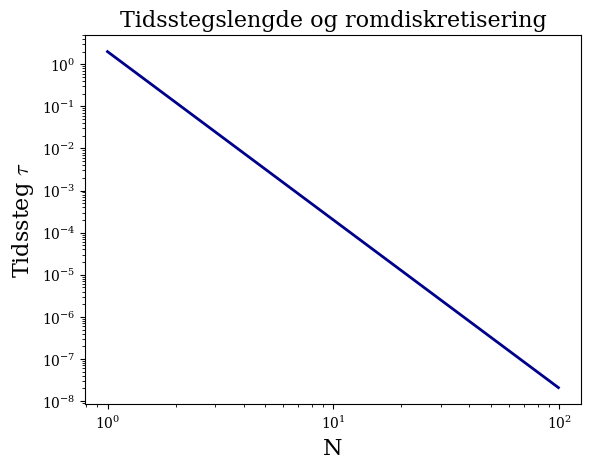

In [85]:
N = np.arange(1,100)
plt.loglog(N,2/N**4, color ="darkblue")
plt.grid()
plt.title("Tidsstegslengde og romdiskretisering")
plt.xlabel("N")
plt.ylabel(r'Tidssteg $\tau$')
plt.show()

Plottet er logaritmisk og viser sammenhengen mellom tidssteget $\tau$ og romdiskretisering.

In [86]:
N_cfl = 20000

Nt_list = [int(0.5*N_cfl), N_cfl, 2*N_cfl,4*N_cfl]

errs3, eocs3 = compute_eoc_transient(kappa=kappa, 
                                   u_ex=u0, U0=U0, g=g,
                                   X=X, Y=Y, t0=t0,theta=0, T=T, Nt_list=Nt_list) 

display(Markdown(r"### 📊 Konvergenstabell for $\theta = 0$"))
table = pd.DataFrame({'Nt': Nt_list, 'error': errs3, 'EOC': eocs3})
display(table)

100%|█████████▉| 0.9999999999999062/1 [00:00<00:00,  2.12it/s] 
100%|█████████▉| 0.9999999999998981/1 [00:00<00:00,  1.11it/s] 
100%|██████████| 1.000000000001004/1 [00:02<00:00,  2.10s/it]  
100%|█████████▉| 0.9999999999993368/1 [00:03<00:00,  3.68s/it] 


### 📊 Konvergenstabell for $\theta = 0$

,Nt,error,EOC
0,10000,NaN,inf
1,20000,0.000465,NaN
2,40000,0.000232,1.00006
3,80000,0.000116,1.00003


I tabellen ser vi at hvis vi har mindre tidssteg enn CFL - betingelsen får vi en feil som ikke gir mening. Når vi derimot har CFL - betingelsen oppfylt får vi en relativt liten feil (som er i lignende størrelsesorden som for de andre metodene), og dette kan tyde på at vi har rett betingelse for stabilitet. Når vi etterhvert velger flere tidssteg enn betingelsen ser vi at metoden ser ut til å ha konsistensorden 1, som er lik for den teoretiske Forward Euler metoden.

### Oppgave 3.3

In [87]:
#string representasjon av funksjonen
u_string_ex = '(exp(1+sin(x)*sin(x)) + exp(1+cos(y)*cos(y)))*exp(-4*kappa*t)'
u_ex,g_exact = manufacture_solution_transistent(u_string_ex,kappa)

u0 = u_ex
U0 = u0(X,Y,0)
g = g_exact

Nt_list = [10,20,40,80,160,320,640]


errs1, eocs1 = compute_eoc_transient(kappa=kappa, 
                                   u_ex=u0, U0=U0, g=g,
                                   X=X, Y=Y, t0=t0,theta=1, T=T, Nt_list=Nt_list)
errs2, eocs2 = compute_eoc_transient(kappa=kappa, 
                                   u_ex=u0, U0=U0, g=g,
                                   X=X, Y=Y, t0=t0,theta=0.5, T=T, Nt_list=Nt_list)

display(Markdown(r"### 📊 Konvergenstabell for $\theta = 1$"))
table1 = pd.DataFrame({'Nt': Nt_list, 'error': errs1, 'EOC': eocs1})
display(table1)
display(Markdown(r"### 📊 Konvergenstabell for $\theta = 0.5$"))
table2 = pd.DataFrame({'Nt': Nt_list, 'error': errs2, 'EOC': eocs2})
display(table2)

u = (exp(sin(x)**2 + 1) + exp(cos(y)**2 + 1))*exp(-4*t)
u0 = exp(sin(x)**2 + 1) + exp(cos(y)**2 + 1)
g = -4*(exp(sin(x)**2 + 1) + exp(cos(y)**2 + 1))*exp(-4*t) + 4*(2*(2*sin(x)**2*cos(x)**2 - sin(x)**2 + cos(x)**2)*sin(x)**2*cos(x)**2 - (2*sin(x)**2*cos(x)**2 - sin(x)**2 + cos(x)**2)*sin(x)**2 + (2*sin(x)**2*cos(x)**2 - sin(x)**2 + cos(x)**2)*cos(x)**2 - 8*(sin(x)**2 - cos(x)**2 + 1)*sin(x)**2*cos(x)**2 + 2*sin(x)**4 - 12*sin(x)**2*cos(x)**2 + 2*sin(x)**2 + 2*cos(x)**4 - 2*cos(x)**2)*exp(-4*t)*exp(sin(x)**2 + 1) + 4*(2*(2*sin(y)**2*cos(y)**2 + sin(y)**2 - cos(y)**2)*sin(y)**2*cos(y)**2 + (2*sin(y)**2*cos(y)**2 + sin(y)**2 - cos(y)**2)*sin(y)**2 - (2*sin(y)**2*cos(y)**2 + sin(y)**2 - cos(y)**2)*cos(y)**2 - 8*(-sin(y)**2 + cos(y)**2 + 1)*sin(y)**2*cos(y)**2 + 2*sin(y)**4 - 12*sin(y)**2*cos(y)**2 - 2*sin(y)**2 + 2*cos(y)**4 + 2*cos(y)**2)*exp(-4*t)*exp(cos(y)**2 + 1)


100%|█████████▉| 0.9999999999999999/1 [00:00<00:00, 250.11it/s]
100%|██████████| 1.0000000000000002/1 [00:00<00:00, 133.06it/s]
100%|██████████| 1.0000000000000004/1 [00:00<00:00, 114.00it/s]
100%|█████████▉| 0.9999999999999984/1 [00:00<00:00, 22.25it/s]
100%|█████████▉| 0.9999999999999974/1 [00:00<00:00, 19.06it/s]
100%|██████████| 1.0000000000000058/1 [00:00<00:00,  9.73it/s]
100%|██████████| 1.00000000000001/1 [00:00<00:00,  3.88it/s]   
100%|█████████▉| 0.9999999999999999/1 [00:00<00:00, 130.27it/s]
100%|██████████| 1.0000000000000002/1 [00:00<00:00, 123.82it/s]
100%|██████████| 1.0000000000000004/1 [00:00<00:00, 63.57it/s]
100%|█████████▉| 0.9999999999999984/1 [00:00<00:00, 21.35it/s]
100%|█████████▉| 0.9999999999999974/1 [00:00<00:00, 17.90it/s]
100%|██████████| 1.0000000000000058/1 [00:00<00:00,  8.84it/s]
100%|██████████| 1.00000000000001/1 [00:00<00:00,  4.47it/s]   


### 📊 Konvergenstabell for $\theta = 1$

,Nt,error,EOC
0,10,35.012751,inf
1,20,18.123685,0.950004
2,40,9.216821,0.975535
3,80,4.647206,0.987906
4,160,2.333309,0.993986
5,320,1.169085,0.996997
6,640,0.585154,0.998492


### 📊 Konvergenstabell for $\theta = 0.5$

,Nt,error,EOC
0,10,2.492500,inf
1,20,0.624555,1.996692
2,40,0.156216,1.999282
3,80,0.039039,2.000566
4,160,0.009760,2.000027
5,320,0.002440,1.999996
6,640,0.000610,2.000025


Vi kan se at også i denne konvergensstudien ser metodene ut til å ha konvergensorden lik $1$ og $2$, som da $g = 0$. Det ser dermed ut til at metoden fungerer bra for både trivielle og ikke- trivielle kildeledd.

## Oppgave 4: IMEX-solver
### Oppgave 4.1

Vi skal innføre en implisitt-eksplisitt metode, som vil si at vi splitter opp ledd og beregner både implisitt og eksplisitt. Det antas at $\theta$ metoden er kjent og vi starter med å beskrive $F(t_n,U^n)$ og $F(t_n + \tau, U^{n+1})$  

Vi starter med:  

$
\partial_t u - \nabla \cdot \left( M \nabla(f(u)) - \kappa \Delta u \right) = g
$

$
\partial_t u = g + M\Delta(f(u)) + M\kappa\Delta^2u
$

$\Delta f(u)$ er definert som:
  
$\Delta f(u) = \Delta(u^3-u) = \alpha\Delta u + \Delta u^3 - (1+\alpha)\Delta u $

Vi får da:  


$
\partial_t u = g + M(\alpha\Delta u + \Delta u^3 - (1+\alpha)\Delta u) + M\kappa\Delta^2u
$


*Nå kan vi dele inn i eksplisitt og implisitt del:*

Eksplisitt del:  

$F(t_n,U^n) = M(\Delta (u^n)^3 - (1+\alpha)\Delta u^n)$

Implisitt del :

$F(t_n + \tau, U^{n+1}) = g^{n+1} + M \alpha \Delta u^{n+1} - M \kappa \Delta^2 u^{n+1}$  


Vi kan nå kombinere de til ett uttrykk:  

$u^{n+1} = u^n + \tau M(\Delta (u^n)^3 - (1+\alpha)\Delta u^n) + \tau (g^{n+1} + M \alpha \Delta u^{n+1} - M \kappa \Delta^2 u^{n+1})$  


### DFT:

$
\hat{u}^{n+1} = \hat{u}^n - \tau M |\tilde{K}|^2 \left( \widehat{(u^n)^3 - (1+\alpha) \hat{u}^n} \right) + \tau \left( \hat{g}^{n+1} - M \alpha |\tilde{K}|^2 \hat{u}^{n+1} - M \kappa |\tilde{K}|^4 \hat{u}^{n+1} \right)
$  

$
\hat{u}^{n+1} = \frac{\hat{u}^n - \tau M |\tilde{K}|^2 \left( \widehat{(u^n)^3 - (1+\alpha) \hat{u}^n} \right) + \tau \hat{g}^{n+1}}{1 + \tau M \alpha |\tilde{K}|^2 + \tau M \kappa |\tilde{K}|^4}
$  

Metoden beregner først $(u^n)^3 - (1+\alpha) u^n$ i det fysiske rommet, og så fouriertransformerer vi, dette gjør at vi slipper konvolusjonen av det beregningstunge ikke-lineære leddet.

### Oppgave 4.2

In [88]:
def cahn_hilliard_backwards_euler(*,kappa,X,Y,U0,t0,T,Nt,alpha,g = None,tau = None):
    x, y = X[0,:], Y[:,0]
    Nx, Ny = len(x), len(y)
    dx, dy = x[1] - x[0], y[1] - y[0]


    #beregner kx og ky i frekvensrommet
    kx = fftfreq(Nx, d=dx/(2*np.pi))
    ky = fftfreq(Ny, d=dy/(2*np.pi))
    KX, KY = np.meshgrid(kx, ky, indexing='ij')

    #biharmonisk operator i frekvensrommet:
    K4 = (KX**2+KY**2)**2

    #laplace operator i frekvensrommet:
    K2 = KX**2+KY**2

    #time stepping
    t = t0
    dt = (T-t0)/Nt
    U_hat = fft2(U0)

    #denne linjern gjør det mulig å sette tidssteget manuelt senere!
    if tau is not None:
        dt = tau

    #returnerer startbetingelsene
    yield (U_hat, t)
    
    with tqdm(total=T) as pbar:
        while t < T-dt/2:
            if g is not None:
                G_hat = fft2(g(X,Y,t))
            else:
                G_hat = 0

            #tar hele u-vektoren tilbake til fysisk space:
            U_real_space =ifft2(U_hat).real

            #beregner høyresiden og tar laplace i fourierspace
            nonlinear = U_real_space**3 - (1+alpha)*U_real_space
            nonlinearFourier = fft2(nonlinear)
        
            #oppdatering av u-vektoren
            teller = U_hat + dt*(G_hat-M*K2*nonlinearFourier)
            nevner = 1 + dt*(M*alpha*K2 + kappa*K4)
            U_hat = teller/nevner

            #setter mean value 
            U_hat[0, 0] = np.mean(ifft2(U_hat)).real * Nx * Ny


           
            t = t + dt
            pbar.update(dt)
            yield U_hat, t

### Oppgave 4.3

In [89]:
#manufacture solutions
def manufacture_solution_cahnHilliard(u_string,kappa,M=1):

    x, y, t = sy.symbols('x y t')
    u_symbolic = eval(u_string)

    laplace = lambda u: sy.diff(u, x, 2) + sy.diff(u, y, 2)

    uDerivative = sy.diff(u_symbolic, t)
    uBiharmonic = kappa*laplace(laplace(u_symbolic))
    uLaplace = M*laplace(u_symbolic**3-u_symbolic)
    g_symbolic = uDerivative + uBiharmonic - uLaplace

    u = sy.lambdify((x, y, t), u_symbolic, modules='numpy')
    g = sy.lambdify((x, y, t), g_symbolic, modules='numpy')
    print(f'u = {u_symbolic}')
    print(f'u0 = {u_symbolic.subs(t, 0)}')
    print(f'g = {g_symbolic}')

    return u,g

In [90]:
#beregner konvergensorden for backwards euler
def compute_eoc_cahnHilliard(*,
                          kappa, u_ex, U0, g,
                          X, Y, t0,alpha, T, Nt_list):
    errs_Nt = [] 
    for Nt in Nt_list:
        U_list = cahn_hilliard_backwards_euler(kappa=kappa,X=X,Y=Y,U0=U0,
                                        t0=t0,T=T,Nt=Nt,alpha = alpha,g = g)
        errs_t = []
        for U, t in U_list:
            U = ifft2(U).real
            U_ex = u_ex(X,Y,t)
            U_err = U - U_ex
            errs_t.append(np.linalg.norm(U_err, np.inf))
        errs_Nt.append(np.array(np.linalg.norm(errs_t, np.inf)))
        
    Nt_list = np.array(Nt_list)
    errs_Nt = np.array(errs_Nt)
    eocs = np.log(errs_Nt[1:]/errs_Nt[:-1])/np.log(Nt_list[:-1]/Nt_list[1:])
    eocs = np.insert(eocs, 0, np.inf)
    return errs_Nt, eocs

In [91]:

#string representasjon av funksjonen
u_string_ex = 'sin(x)*cos(y)*exp(-4*kappa*t)'
u_ex0,g_exact0 = manufacture_solution_cahnHilliard(u_string_ex,kappa=1)
u_ex1,g_exact1 = manufacture_solution_cahnHilliard(u_string_ex,kappa=0.01)

u = exp(-4*t)*sin(x)*cos(y)
u0 = sin(x)*cos(y)
g = -(1 + 6*exp(-8*t)*sin(x)**2*sin(y)**2 - 3*exp(-8*t)*sin(x)**2*cos(y)**2)*exp(-4*t)*sin(x)*cos(y) - (1 - 3*exp(-8*t)*sin(x)**2*cos(y)**2 + 6*exp(-8*t)*cos(x)**2*cos(y)**2)*exp(-4*t)*sin(x)*cos(y)
u = exp(-0.04*t)*sin(x)*cos(y)
u0 = sin(x)*cos(y)
g = -(6*exp(-0.12*t)*sin(x)**2*sin(y)**2 - 3*exp(-0.12*t)*sin(x)**2*cos(y)**2 + exp(-0.04*t))*sin(x)*cos(y) - (-3*exp(-0.12*t)*sin(x)**2*cos(y)**2 + 6*exp(-0.12*t)*cos(x)**2*cos(y)**2 + exp(-0.04*t))*sin(x)*cos(y)


In [92]:
#løsningsforberedelser
Lx,Ly = 16*np.pi,16*np.pi
Nx,Ny =64,64
x = np.linspace(0,Lx,Nx,endpoint=False)
y = np.linspace(0,Ly,Ny,endpoint=False)
X,Y = np.meshgrid(x,y,sparse=True)

#parametere
kappa = 1
T,t0 = 1,0
alpha2 = 1.5
alpha1 = 0.5
alpha3 = 3
M= 1

Nt_list = [100,200,400,800,1600,3200]


#kappa = 1
gk0 = g_exact0
uk0 = u_ex0
Uk0 = uk0(X,Y,0)

#kappa = 0.01
gk1 = g_exact1
uk1 = u_ex1
Uk1 = uk1(X,Y,0)

                    
errs1, eocs1 = compute_eoc_cahnHilliard(
                          kappa=1, u_ex=uk0, U0=Uk0, g=gk0,
                          X=X, Y=Y, t0=t0,alpha=alpha1, T=T, Nt_list=Nt_list)
errs12, eocs12 = compute_eoc_cahnHilliard(
                          kappa=1, u_ex=uk0, U0=Uk0, g=gk0,
                          X=X, Y=Y, t0=t0,alpha=alpha2, T=T, Nt_list=Nt_list)
errs13, eocs13 = compute_eoc_cahnHilliard(
                          kappa=1, u_ex=uk0, U0=Uk0, g=gk0,
                          X=X, Y=Y, t0=t0,alpha=alpha3, T=T, Nt_list=Nt_list)

errs2, eocs2 = compute_eoc_cahnHilliard(
                          kappa=0.01, u_ex=uk1, U0=Uk1, g=gk1,
                          X=X, Y=Y, t0=t0,alpha=alpha1, T=T, Nt_list=Nt_list)

errs3, eocs3 = compute_eoc_cahnHilliard(
                          kappa=0.01, u_ex=uk1, U0=Uk1, g=gk1,
                          X=X, Y=Y, t0=t0,alpha=alpha2, T=T, Nt_list=Nt_list)

errs4, eocs4 = compute_eoc_cahnHilliard(
                          kappa=0.01, u_ex=uk1, U0=Uk1, g=gk1,
                          X=X, Y=Y, t0=t0,alpha=alpha3, T=T, Nt_list=Nt_list)


display(Markdown(r"### 📊 Konvergenstabell for $\kappa = 1$, $\alpha = 0.5$" ))
table1 = pd.DataFrame({'Nt': Nt_list, 'error': errs1, 'EOC': eocs1})
display(table1)
display(Markdown(r"### 📊 Konvergenstabell for $\kappa = 0.01$, $\alpha = 0.5$"))
table2 = pd.DataFrame({'Nt': Nt_list, 'error': errs2, 'EOC': eocs2})
display(table2)

display(Markdown(r"### 📊 Konvergenstabell for $\kappa = 1$, $\alpha = 1.5$" ))
table1 = pd.DataFrame({'Nt': Nt_list, 'error': errs12, 'EOC': eocs12})
display(table1)
display(Markdown(r"### 📊 Konvergenstabell for $\kappa = 0.01$, $\alpha = 1.5$"))
table2 = pd.DataFrame({'Nt': Nt_list, 'error': errs3, 'EOC': eocs3})
display(table2)

display(Markdown(r"### 📊 Konvergenstabell for $\kappa = 1$, $\alpha = 3$" ))
table1 = pd.DataFrame({'Nt': Nt_list, 'error': errs13, 'EOC': eocs13})
display(table1)
display(Markdown(r"### 📊 Konvergenstabell for $\kappa = 0.01$, $\alpha = 3$"))
table2 = pd.DataFrame({'Nt': Nt_list, 'error': errs4, 'EOC': eocs4})
display(table2)

100%|██████████| 1.0000000000000007/1 [00:00<00:00, 20.44it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00, 10.64it/s]
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  2.82it/s] 
100%|█████████▉| 0.9999999999999842/1 [00:00<00:00,  2.10it/s] 
100%|█████████▉| 0.9999999999999815/1 [00:00<00:00,  1.19it/s] 
100%|██████████| 1.0000000000000688/1 [00:01<00:00,  1.63s/it] 
100%|██████████| 1.0000000000000007/1 [00:00<00:00, 21.19it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  8.64it/s]
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  5.52it/s]
100%|█████████▉| 0.9999999999999842/1 [00:00<00:00,  2.54it/s] 
100%|█████████▉| 0.9999999999999815/1 [00:01<00:00,  1.02s/it] 
100%|██████████| 1.0000000000000688/1 [00:01<00:00,  1.56s/it] 
100%|██████████| 1.0000000000000007/1 [00:00<00:00, 21.78it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00, 10.46it/s]
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  5.36it/s]
100%|█████████▉| 0.9999999999999842/1 [00:00<00:

### 📊 Konvergenstabell for $\kappa = 1$, $\alpha = 0.5$

,Nt,error,EOC
0,100,0.493603,inf
1,200,0.250262,0.979916
2,400,0.126015,0.989837
3,800,0.063231,0.994888
4,1600,0.031672,0.997433
5,3200,0.015850,0.998714


### 📊 Konvergenstabell for $\kappa = 0.01$, $\alpha = 0.5$

,Nt,error,EOC
0,100,0.025655,inf
1,200,0.013286,0.949333
2,400,0.006765,0.973675
3,800,0.003414,0.986575
4,1600,0.001715,0.993220
5,3200,0.000860,0.996593


### 📊 Konvergenstabell for $\kappa = 1$, $\alpha = 1.5$

,Nt,error,EOC
0,100,0.814713,inf
1,200,0.415028,0.973082
2,400,0.209498,0.986275
3,800,0.105253,0.993080
4,1600,0.052753,0.996524
5,3200,0.026408,0.998258


### 📊 Konvergenstabell for $\kappa = 0.01$, $\alpha = 1.5$

,Nt,error,EOC
0,100,0.069291,inf
1,200,0.037423,0.888746
2,400,0.019516,0.939307
3,800,0.009975,0.968211
4,1600,0.005044,0.983719
5,3200,0.002537,0.991759


### 📊 Konvergenstabell for $\kappa = 1$, $\alpha = 3$

,Nt,error,EOC
0,100,1.282962,inf
1,200,0.658626,0.961947
2,400,0.333802,0.980466
3,800,0.168051,0.990097
4,1600,0.084316,0.995015
5,3200,0.042231,0.997499


### 📊 Konvergenstabell for $\kappa = 0.01$, $\alpha = 3$

,Nt,error,EOC
0,100,0.122752,inf
1,200,0.069653,0.817503
2,400,0.037477,0.894183
3,800,0.019500,0.942525
4,1600,0.009955,0.969969
5,3200,0.005031,0.984639


#### Diskusjon til resultatene:

Det første vi ser er at metoden ser ut til å ha konsistenssorden 1. Dette er forventet for Eulers metode. Samtidig kan man se at hvor raskt man oppnår dette konvergensorden er avhengig av $\kappa$ og $\alpha$. La oss nå se nærmere på disse parameterene:

#### **$\kappa$** (*energigradient koeffesient*):

Tar utgangspunkt i:  

$
\hat{u}^{n+1} = \frac{\hat{u}^n - \tau M |\tilde{K}|^2 \left( \widehat{(u^n)^3 - (1+\alpha) \hat{u}^n} \right) + \tau \hat{g}^{n+1}}{1 + \tau M \alpha |\tilde{K}|^2 + \tau M \kappa |\tilde{K}|^4}
$ 

Større verdier for $\kappa$ gjør at nevneren blir større og dermed at $\hat{u}^{n+1}$ mindre. Dette gjør at  når $\kappa = 1$ blir høye frekvenser dempet mer, dette gjør løsningen glattere. I neste omgang fører dette til at det er lettere å få en god konsistensorden for en lavere tidsdisktretisering. I motsatt tilfelle vil en lav $\kappa$ verdi sørge for at $\hat{u}^{n+1}$ blir større, og dermed at høyere frekvenser "slipper" gjennom. Dette gjør at vi får skarpere løsning, som også trenger større tidsdiskretinsering for å oppnå en god konvergens. Dette er noe som også kommer frem i tabellene.   

Samtidig kan vi også ta utgangspunkt i CFL - betingelsen. Vi ser på uttrykket fra oppgave 3. Det vil ikke bli helt likt, men $\kappa$ vil uansett havne i nevneren. Dette gjør at samme argument også holder i dette tilfellet. Vi kan ta høyere tidssteg ved en høyere $\kappa$, og motsatt for en lavere verdi av $\kappa$


#### **$\alpha$** (*forholdet mellom eksplisitt og implisitt del*):

Splitting av den implisitte og den eksplitte delen skjer slik:

$
\Delta f(u) = \Delta(u^3 - u) = \underbrace{a \Delta u}_{f_1(u)} + \underbrace{\Delta u^3 - (1+a) \Delta u}_{f_2(u)}.
$

Hvor $f_1$ behandles implisitt og $f_2$ behandles eksplisitt, fra tabellene over ser vi at EOC er høyere i starten hvis $\alpha$ er liten. Dette gjør at den eksplisitte delen får større betydning. De største forskjellene ser vi når $\kappa = 0.01$. Dette kan tyde på at ved å gi den eksplisitte delen mer vekt ,vil metoden konvergere raskere i starten (ved færre tidssteg). 


## Oppgave 5
### Oppgave 5.1

Vi ønsker å vise at det semi-implisitte Song-skjemaet har konsistensorden $p = 2$. Det vil si, vise at den lokale trunkeringsfeilen ${\eta}_1 = U(t_0 + \tau) - U_1$ er av orden $\mathcal{O}(\tau^{p + 1}) = \mathcal{O}(\tau^{3})$.

Det semi-implisitte Song-skjemaet er definert som:

\begin{aligned}
U^{(1)} &= U^n + \tau \left( L U^{(1)} + \mathbf{N}(U^n) \right), \\
U^{(2)} &= \alpha_{10} U^n + \alpha_{11} U^{(1)} + \beta_1 \tau \left( L U^{(2)} + \mathbf{N}(U^{(1)}) \right), \\
U^{n+1} &= \alpha_{20} U^n + \alpha_{21} U^{(1)} + \alpha_{22} U^{(2)} + \beta_2 \tau \left( L U^{n+1} + \mathbf{N}(U^{(2)}) \right).
\end{aligned}

#### Taylorutvikler $U^{(1)}$ rundt $t = t_0$:

Vi antar at løsningen har Taylorformen

$U^{(1)} = U^n + \tau A + \tau^2 B + \mathcal{O}(\tau^{3})$,

hvor $A$ og $B$ er uttrykk vi skal bestemme. 

Utgangspunktet er definisjonen av $U^{(1)}$ fra Song-skjemaet

$U^{(1)} = U^n + \tau(LU^{(1)} + N(U^n))$,

hvor vi setter inn taylorutviklingen av $U^{(1)}$ på begge sider, slik at:

$U^n + \tau A + \tau^2 B + \mathcal{O}(\tau^{3}) = U^n + \tau(L (U^n + \tau A + \tau^2 B + \mathcal{O}(\tau^{3})) + N(U^n))$

$U^n + \tau A + \tau^2 B + \mathcal{O}(\tau^{3}) = U^n + \tau L U^n + \tau N(U^n) + \tau^2 L A + \mathcal{O}(\tau^{3})$

Samler ledd etter orden i $\tau$ og sammenligner venstre side med høyre side:

- $1.$ orden: $A = L U^n + N(U^n)$
- $2.$ orden: $B = L A = L^2 U^n + L N(U^n)$

Dermed:

$U^{(1)} = U^n + \tau (L U^n + N(U^n)) + \tau^2 L (L U^n + N(U^n)) + \mathcal{O}(\tau^{3})$

#### Taylorutvikler $U^{(2)}$ rundt $t = t_0$:

Vi antar at løsningen har Taylorformen

$U^{(2)} = U^n + \tau C + \tau^2 D + \mathcal{O}(\tau^3)$,

hvor $C$ og $D$ er uttrykk vi skal bestemme.

Utgangspunktet er definisjonen av $U^{(2)}$ i Song-skjemaet:

$
U^{(2)} = \alpha_{10} U^n + \alpha_{11} U^{(1)} + \beta_1 \tau \left( L U^{(2)} + \mathbf{N}(U^{(1)}) \right)
$

Vi setter inn Taylorutviklingene
- $U^{(1)} = U^n + \tau A + \tau^2 B + \mathcal{O}(\tau^3)$
- $U^{(2)} = U^n + \tau C + \tau^2 D + \mathcal{O}(\tau^3)$

på begge sider:

$U^n + \tau C + \tau^2 D + \mathcal{O}(\tau^3) = a_{10} U^n + a_{11}(U^n + \tau A + \tau^2 B + \mathcal{O}(\tau^{3})) + {\beta}_1 \tau (L(U^n + \tau C + \tau^2 D) + N(U^n + \tau A + \tau^2 B + \mathcal{O}(\tau^3)))$

Da $N$ er en ikke-lineær funksjon kan vi ikke direkte trekke ut argumentene, men må heller Taylorutvikle $N$. 
En generell Taylorutvidelse for
- en funksjon $N: \mathbb{R}^n \rarr \mathbb{R}^n$,
- med et punkt $a \in \mathbb{R}^n$, her: $U^n$,
- en liten endring $h \in \mathbb{R}^n$, her: $\tau A + \tau^2 B$,

er gitt som:

$N(a + h) = N(a) + N'(a)h + \frac{1}{2}N''(a)[h,h] + ...$

hvor 
- $N'(a)$ er Jacobi-matrisen. Beskriver hvordan den ikke-lineære helningen endrer seg langs $h$.
- $N''(a)$ er et Hessian-tensorfelt. Beskriver hvordan den ikke-lineære endringen krummer langs $h$.


Setter inn $U^{(1)}$ som argument for $N$, bruker kjernergelen og får:

$N(U^{(1)}) = N(U^n + \tau A + \tau^2 B + \mathcal{O}(\tau^3))$

$N(U^{(1)}) = N(U^n) + N'(U^n)\tau A + N'(U^n) \tau^2 B + \frac{1}{2}(N''(U^n)[\tau A + \tau^2 B, \tau A + \tau^2 B])$

Antar symmetrisk $N''$, bruker binlinearitet, trekker ut faktorer og summerer:

$N(U^{(1)}) = N(U^n) + N'(U^n)\tau A + N'(U^n) \tau^2 B + \frac{1}{2}(N''\tau^2(U^n)[A, A] + N''(U^n)2\tau^3[A, B] + N''(U^n)\tau^4[B,B])$

$N(U^{(1)}) = N(U^n) + N'(U^n)\tau A + N'(U^n) \tau^2 B + \frac{1}{2}(N''\tau^2(U^n)[A, A]) + \mathcal{O}(\tau^3)$

Dermed kan Taylorutviklingen av $U^{(2)}$ nå skrives som:

$U^n + \tau C + \tau^2 D + \mathcal{O}(\tau^3) = a_{10} U^n + a_{11}(U^n + \tau A + \tau^2 B + \mathcal{O}(\tau^{3})) + {\beta}_1 \tau (L(U^n + \tau C + \tau^2 D) + N(U^n) + \tau N'(U^n)[A] + \tau^2(N'(U^n)[B] + \frac{1}{2}N''(U^n)[A,A])) + \mathcal{O}(\tau^3)$

Samler ledd etter orden i $\tau$ og sammenligner venstre side med høyre side:

- $0.$ orden:
  $U^n = (a_{10} + a_{11})U^n$

- $1.$ orden:
  $C = \alpha_{11} A + \beta_1 (L U^n + \mathbf{N}(U^n))$

- $1.$ orden:
  $D = \alpha_{11} B + \beta_1 (L C + \mathbf{N}'(U^n) A)$

Dermed:
$U^{(2)} = U^n + \tau (\alpha_{11} A + \beta_1 (L U^n + \mathbf{N}(U^n))) + \tau^2 (\alpha_{11} B + \beta_1 (L C + \mathbf{N}'(U^n) A))$

#### Taylorutvikler $U^{n+1}$ rundt $t = t_0$:

Vi antar at løsningen har Taylorformen

$U^{n+1} = U^n + \tau E + \tau^2 F + \mathcal{O}(\tau^3)$,

hvor $E$ og $F$ er uttrykk vi ønsker å bestemme.

Utgangspunktet er definisjonen av $U^{n+1}$ i Song-skjemaet:

$
U^{n+1} = \alpha_{20} U^n + \alpha_{21} U^{(1)} + \alpha_{22} U^{(2)} + \beta_2 \tau \left( L U^{n+1} + \mathbf{N}(U^{(2)}) \right)
$

Vi setter inn Taylorutviklingene:
- $U^{(1)} = U^n + \tau A + \tau^2 B + \mathcal{O}(\tau^3)$
- $U^{(2)} = U^n + \tau C + \tau^2 D + \mathcal{O}(\tau^3)$
- $U^{n+1} = U^n + \tau E + \tau^2 F + \mathcal{O}(\tau^3)$

Vi trenger også Taylorutvikling av $\mathbf{N}(U^{(2)})$:

\begin{aligned}
\mathbf{N}(U^{(2)}) &= \mathbf{N}(U^n + \tau C + \tau^2 D + \mathcal{O}(\tau^3)) \\
&= \mathbf{N}(U^n) + \tau \mathbf{N}'(U^n)[C] + \tau^2 \left( \mathbf{N}'(U^n)[D] + \frac{1}{2} \mathbf{N}''(U^n)[C, C] \right) + \mathcal{O}(\tau^3)
\end{aligned}


Setter alt inn i høyresiden:

$
\begin{aligned}
U^{n+1} &= \alpha_{20} U^n + \alpha_{21}(U^n + \tau A + \tau^2 B) + \alpha_{22}(U^n + \tau C + \tau^2 D) \\
&\quad + \beta_2 \tau \left( L(U^n + \tau E + \tau^2 F) + \mathbf{N}(U^n) + \tau \mathbf{N}'(U^n)[C] + \tau^2 \left( \mathbf{N}'(U^n)[D] + \frac{1}{2} \mathbf{N}''(U^n)[C, C] \right) \right) + \mathcal{O}(\tau^3)
\end{aligned}
$

Utvider og samler ledd:

- $0.$ orden:
  $U^n = (\alpha_{20} + \alpha_{21} + \alpha_{22}) U^n$

- $1.$ orden:
  $E = \alpha_{21} A + \alpha_{22} C + \beta_2 (L U^n + \mathbf{N}(U^n))$

- $2.$ orden:
  $F = \alpha_{21} B + \alpha_{22} D + \beta_2 \left( L E + \mathbf{N}'(U^n)[C] \right)$

Dermed får vi Taylorutviklingen:

$
U^{n+1} = U^n + \tau E + \tau^2 F + \mathcal{O}(\tau^3)
$

hvor

- $E = \alpha_{21} A + \alpha_{22} C + \beta_2 (L U^n + \mathbf{N}(U^n))$
- $F = \alpha_{21} B + \alpha_{22} D + \beta_2 (L E + \mathbf{N}'(U^n)[C])$

#### Sammenligning med eksakt løsning:

Den eksakte Taylorutviklingen av løsningen $U(t)$ rundt $t = t_0$ er:

$
U(t_0 + \tau) = U^n + \tau U'(t_0) + \frac{\tau^2}{2} U''(t_0) + \mathcal{O}(\tau^3)
$

Fra definisjonen av den generelle ODEen bruker vi at:

- $U'(t_0) = L U^n + \mathbf{N}(U^n) = A$
- $U''(t_0) = L A + \mathbf{N}'(U^n)[A] = B + \mathbf{N}'(U^n)[A]$

Dermed får vi:

$
U(t_0 + \tau) = U^n + \tau A + \frac{\tau^2}{2} (B + \mathbf{N}'(U^n)[A]) + \mathcal{O}(\tau^3)
$

Fra utledningen over fikk vi:

$
U^{n+1} = U^n + \tau E + \tau^2 F + \mathcal{O}(\tau^3)
$

For at den lokale trunkeringsfeilen skal være av orden $\mathcal{O}(\tau^3)$, må vi ha:

- $\tau$-leddet: $E = A$
- $\tau^2$-leddet: $F = \frac{1}{2}(B + \mathbf{N}'(U^n)[A])$

#### Første betingelse ($\tau$-ledd):

Vi hadde:

- $C = \alpha_{11} A + \beta_1 (L U^n + \mathbf{N}(U^n))$
- $E = \alpha_{21} A + \alpha_{22} C + \beta_2 (L U^n + \mathbf{N}(U^n))$

Setter inn $C$ i uttrykket for $E$:

$
\begin{aligned}
E &= \alpha_{21} A + \alpha_{22} (\alpha_{11} A + \beta_1 (L U^n + \mathbf{N}(U^n))) + \beta_2 (L U^n + \mathbf{N}(U^n)) \\
&= (\alpha_{21} + \alpha_{22} \alpha_{11}) A + (\alpha_{22} \beta_1 + \beta_2)(L U^n + \mathbf{N}(U^n)) \\
&= \left( \alpha_{21} + \alpha_{22} \alpha_{11} + \alpha_{22} \beta_1 + \beta_2 \right) A
\end{aligned}
$

Siden $A = L U^n + \mathbf{N}(U^n)$, får vi betingelsen:

$
\boxed{ \alpha_{21} + \alpha_{22} \alpha_{11} + \alpha_{22} \beta_1 + \beta_2 = 1 }
$

#### Øvrige konsistensbetingelser

Fra tidligere utviklinger fikk vi også:

- Fra $U^{(2)}$:

  $
  \boxed{ \alpha_{10} + \alpha_{11} = 1 }
  $

- Fra $U^{n+1}$:

  $
  \boxed{ \alpha_{20} + \alpha_{21} + \alpha_{22} = 1 }
  $

#### Konklusjon

Ved å sammenligne Taylorutviklingen av den numeriske løsningen $U^{n+1}$ og den eksakte løsningen $U(t_0 + \tau)$, får vi tre konsistensbetingelser som må være oppfylt for at metoden skal ha lokal trunkeringsfeil av orden $\mathcal{O}(\tau^3)$. Dette gir konsistensorden $p = 2$:

- $\alpha_{10} + \alpha_{11} = 1$
- $\alpha_{20} + \alpha_{21} + \alpha_{22} = 1$
- $\alpha_{21} + \alpha_{22} \alpha_{11} + \alpha_{22} \beta_1 + \beta_2 = 1$

Dermed er det vist at Song-skjemaet er konsistent av orden $p = 2$.


### Oppgave 5.2:

3- stegs IMEX Runge Kutta metoden vår er gitt ved:

$
\begin{aligned}
U^{(1)} &= U^n + \tau \left( \mathbf{L} U^{(1)} + \mathbf{N}(U^n) \right), \\
U^{(2)} &= \alpha_{10} U^n + \alpha_{11} U^{(1)} + \beta_1 \tau \left( \mathbf{L} U^{(2)} + \mathbf{N}(U^{(1)}) \right), \\
U^{n+1} &= \alpha_{20} U^n + \alpha_{21} U^{(1)} + \alpha_{22} U^{(2)} + \beta_2 \tau \left( \mathbf{L} U^{n+1} + \mathbf{N}(U^{(2)}) \right).
\end{aligned}
$

Generelt sett er $U^{n+1}$ delt opp i en eksplisitt del og en implisitt del slik:  


$
\hat{u}^{n+1} = \hat{u}^n - \tau M |\tilde{K}|^2 \left( \widehat{(u^n)^3 - (1+\alpha) \hat{u}^n} \right) + \tau \left( \hat{g}^{n+1} - M \alpha |\tilde{K}|^2 \hat{u}^{n+1} - M \kappa |\tilde{K}|^4 \hat{u}^{n+1} \right)
$ 

#### Steg 1:
  

$
\hat{u}^{1} = \hat{u}^n - \tau M |\tilde{K}|^2 \left( \widehat{(u^n)^3 - (1+\alpha) {u}^n} \right) + \tau \left( \hat{g}^{1} - M \alpha |\tilde{K}|^2 \hat{u}^{1} - M \kappa |\tilde{K}|^4 \hat{u}^{1} \right)
$ 

Så flytter vi over og oppnår for steg 1:

$
\hat{u}^{1} = \frac{\hat{u}^n + \tau(\hat{g}^1 - M |\tilde{K}|^2 ( \widehat{(u^n)^3 - (1+\alpha) u^n}))}{1 + \tau(\alpha M |\tilde{K}|^2 + M \kappa |\tilde{K}|^4)}
$

#### Steg 2:

$
\hat{u}^2 = \alpha_{10} U^n + \alpha_{11} U^{(1)} + \beta_1 \tau(-M |\tilde{K}|^2 ( \widehat{(u^1)^3 - (1+\alpha) {u}^1} +  \hat{g}^{2} - M \alpha |\tilde{K}|^2 \hat{u}^{2} - M \kappa |\tilde{K}|^4 \hat{u}^{2})) 
$

Vi oppnår: 

$
\hat{u}^2 = \frac{\alpha_{10} \hat{u}^n + \alpha_{11} \hat{u}^{(1)} + \beta_1 \tau (\hat{{g}}^2 - M |\tilde{K}|^2 ( \widehat{(u^1)^3 - (1+\alpha) {u}^1}))}{1 + \beta_1 \tau(\alpha M |\tilde{K}|^2 + M \kappa |\tilde{K}|^4)}
$


#### Steg 3:

$
\hat{u}^{n+1} = \alpha_{20} \hat{u}^n + \alpha_{21} \hat{u}^1 + \alpha_{22} \hat{u}^2 + \beta_2 \tau (-M |\tilde{K}|^2 ( \widehat{(u^2)^3 - (1+\alpha) {u}^2} +  \hat{g}^{n+1} - M \alpha |\tilde{K}|^2 \hat{u}^{n+1} - M \kappa |\tilde{K}|^4 \hat{u}^{n+1}))
$

Vi oppnår:

$
\hat{u}^{n+1} = \frac{\alpha_{20} \hat{u}^n + \alpha_{21} \hat{u}^1 + \alpha_{22} \hat{u}^2 + \beta_2 \tau (\hat{g}^{n+1} - M |\tilde{K}|^2 ( \widehat{(u^2)^3 - (1+\alpha) {u}^2})}{1 + \beta_2 \tau(\alpha M |\tilde{K}|^2 + M \kappa |\tilde{K}|^4)}
$
  
Vi har fulgt den modifiserte metoden der:

$\hat{g}^k = \mathbf{G}^{n + 1/2} = \mathbf{G}\left(t_n + \frac{\tau}{2}\right)$

for $k = 1,2, n+1$

### Oppgave 5.3

In [93]:
def cahn_hilliard_RK(*,kappa,X,Y,U0,t0,T,Nt,alpha,parameterlist,g = None,tau = None):
    x, y = X[0,:], Y[:,0]
    Nx, Ny = len(x), len(y)
    dx, dy = x[1] - x[0], y[1] - y[0]
    alfa10,alfa11,alfa20,alfa21,alfa22,beta1,beta2 = parameterlist


    #beregner kx og ky i frekvensrommet
    kx = fftfreq(Nx, d=dx/(2*np.pi))
    ky = fftfreq(Ny, d=dy/(2*np.pi))
    KX, KY = np.meshgrid(kx, ky, indexing='ij')

    #biharmonisk operator i frekvensrommet:
    K4 = (KX**2+KY**2)**2

    #laplace operator i frekvensrommet:
    K2 = KX**2+KY**2

    #time stepping
    t = t0
    dt = (T-t0)/Nt
    U_hat = fft2(U0)
    if tau is not None:
        dt = tau

    #returnerer startbetingelsene
    yield (U_hat, t)
    
    with tqdm(total=T) as pbar:
        while t < T-dt/2:
            if g is not None:
                G_hat = fft2(g(X,Y,t +dt/2))
            else:
                G_hat= 0
            
            M = 1

            #Kopierer U_hat som U^n
            U_hat_n = U_hat

            #step1
            U_real_space = ifft2(U_hat_n).real
            nonlinear = U_real_space**3 - (1+alpha)*U_real_space
            nonlinearFourier = fft2(nonlinear)

            U_hat_1 = (U_hat_n + dt*(G_hat - M*K2*nonlinearFourier))/(1+dt*(alpha*M*K2 + kappa*K4))

            #step2
            U_real_space = ifft2(U_hat_1).real
            nonlinear = U_real_space**3 - (1+alpha)*U_real_space
            nonlinearFourier = fft2(nonlinear)

            U_hat_2 = (alfa10*U_hat_n + alfa11*U_hat_1 + beta1*dt*(G_hat - M*K2*nonlinearFourier))/(1+ beta1*dt*(alpha*M*K2+kappa*K4))

            #step3
            U_real_space = ifft2(U_hat_2).real
            nonlinear = U_real_space**3 - (1+alpha)*U_real_space
            nonlinearFourier = fft2(nonlinear)

            U_hat = (alfa20*U_hat_n + alfa21*U_hat_1 + alfa22*U_hat_2 + beta2*dt*(G_hat - M*K2*nonlinearFourier))/(1+beta2*dt*(alpha*M*K2+kappa*K4))


            U_hat[0, 0] = np.mean(ifft2(U_hat)).real * Nx * Ny

           
            t = t + dt
            pbar.update(dt)
            yield U_hat, t

In [94]:
def compute_eoc_cahnHilliard(*,
                          kappa, u_ex, U0, g,
                          X, Y, t0,alpha,parameterlist, T, Nt_list):
    errs_Nt = [] 
    for Nt in Nt_list:
        U_list = cahn_hilliard_RK(kappa=kappa,X=X,Y=Y,U0=U0,t0=t0,T=T,Nt=Nt,alpha=alpha,parameterlist=parameterlist,g = g)
        errs_t = []
        for U, t in U_list:
            U = ifft2(U).real
            U_ex = u_ex(X,Y,t)
            U_err = U - U_ex
            errs_t.append(np.linalg.norm(U_err, np.inf))
        errs_Nt.append(np.array(np.linalg.norm(errs_t, np.inf)))
        
    Nt_list = np.array(Nt_list)
    errs_Nt = np.array(errs_Nt)
    eocs = np.log(errs_Nt[1:]/errs_Nt[:-1])/np.log(Nt_list[:-1]/Nt_list[1:])
    eocs = np.insert(eocs, 0, np.inf)
    return errs_Nt, eocs

In [95]:
#løsningsforberedelser
Lx,Ly = 16*np.pi,16*np.pi
Nx,Ny =64,64
x = np.linspace(0,Lx,Nx,endpoint=False)
y = np.linspace(0,Ly,Ny,endpoint=False)
X,Y = np.meshgrid(x,y,sparse=True)

#parametere
kappa = 0.01
T,t0 = 1,0
alpha = 1.5
M= 1

parameterlist1 = [3/2,-1/2,0,0,1,1/2,1]
parameterlist2 = [2,-1,1/2,0,1/2,1,1]
parameterlist3 = [2,-1,0,1/2,1/2,1,1/2]
parameterlist4 = [5/2,-3/2,2/3,0,1/3,3/2,1]

Nt_list = [100,200,400,800,1600,3200]


#string representasjon av funksjonen
u_string_ex = 'sin(x)*cos(y)*exp(-4*kappa*t)'
u_ex1,g_exact1 = manufacture_solution_cahnHilliard(u_string_ex,kappa=0.01)


#kappa = 0.01
gk = g_exact1
u = u_ex1
UK = u(X,Y,0)

                    
errs1, eocs1 = compute_eoc_cahnHilliard(
                          kappa=0.01, u_ex=u, U0=UK, g=gk,
                          X=X, Y=Y, t0=t0,alpha=alpha,parameterlist=parameterlist1, T=T, Nt_list=Nt_list)

errs2, eocs2 = compute_eoc_cahnHilliard(
                          kappa=0.01, u_ex=u, U0=UK, g=gk,
                          X=X, Y=Y, t0=t0,alpha=alpha,parameterlist=parameterlist2, T=T, Nt_list=Nt_list)

errs3, eocs3 = compute_eoc_cahnHilliard(
                          kappa=0.01, u_ex=u, U0=UK, g=gk,
                          X=X, Y=Y, t0=t0,alpha=alpha,parameterlist=parameterlist3, T=T, Nt_list=Nt_list)

errs4, eocs4 = compute_eoc_cahnHilliard(
                          kappa=0.01, u_ex=u, U0=UK, g=gk,
                          X=X, Y=Y, t0=t0,alpha=alpha,parameterlist=parameterlist4, T=T, Nt_list=Nt_list)


display(Markdown(r"### 📊 Konvergenstabell for parametersett 1"))
table1 = pd.DataFrame({'Nt': Nt_list, 'error': errs1, 'EOC': eocs1})
display(table1)

display(Markdown(r"### 📊 Konvergenstabell for parametersett 2"))
table2 = pd.DataFrame({'Nt': Nt_list, 'error': errs2, 'EOC': eocs2})
display(table2)

display(Markdown(r"### 📊 Konvergenstabell for parametersett 3"))
table3 = pd.DataFrame({'Nt': Nt_list, 'error': errs3, 'EOC': eocs3})
display(table3)

display(Markdown(r"### 📊 Konvergenstabell for parametersett 4"))
table4 = pd.DataFrame({'Nt': Nt_list, 'error': errs4, 'EOC': eocs4})
display(table4)

u = exp(-0.04*t)*sin(x)*cos(y)
u0 = sin(x)*cos(y)
g = -(6*exp(-0.12*t)*sin(x)**2*sin(y)**2 - 3*exp(-0.12*t)*sin(x)**2*cos(y)**2 + exp(-0.04*t))*sin(x)*cos(y) - (-3*exp(-0.12*t)*sin(x)**2*cos(y)**2 + 6*exp(-0.12*t)*cos(x)**2*cos(y)**2 + exp(-0.04*t))*sin(x)*cos(y)


100%|██████████| 1.0000000000000007/1 [00:00<00:00, 10.35it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  5.30it/s]
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  2.70it/s]
100%|█████████▉| 0.9999999999999842/1 [00:00<00:00,  1.20it/s] 
100%|█████████▉| 0.9999999999999815/1 [00:01<00:00,  1.59s/it] 
100%|██████████| 1.0000000000000688/1 [00:03<00:00,  3.45s/it] 
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  6.27it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  4.45it/s]
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  2.06it/s]
100%|█████████▉| 0.9999999999999842/1 [00:00<00:00,  1.19it/s] 
100%|█████████▉| 0.9999999999999815/1 [00:01<00:00,  1.76s/it] 
100%|██████████| 1.0000000000000688/1 [00:03<00:00,  3.03s/it] 
100%|██████████| 1.0000000000000007/1 [00:00<00:00, 11.49it/s]
100%|██████████| 1.0000000000000007/1 [00:00<00:00,  5.28it/s]
100%|█████████▉| 0.9999999999999897/1 [00:00<00:00,  3.01it/s]
100%|█████████▉| 0.9999999999999842/1 [00:00<00:0

### 📊 Konvergenstabell for parametersett 1

,Nt,error,EOC
0,100,0.002774,inf
1,200,0.000711,1.964438
2,400,0.000177,2.004117
3,800,0.000044,2.010911
4,1600,0.000011,2.008287
5,3200,0.000003,2.004676


### 📊 Konvergenstabell for parametersett 2

,Nt,error,EOC
0,100,0.000809,inf
1,200,0.000360,1.168421
2,400,0.000117,1.624302
3,800,0.000033,1.817976
4,1600,0.000009,1.909999
5,3200,0.000002,1.954876


### 📊 Konvergenstabell for parametersett 3

,Nt,error,EOC
0,100,0.002592,inf
1,200,0.000680,1.930449
2,400,0.000173,1.977733
3,800,0.000043,1.993856
4,1600,0.000011,1.998461
5,3200,0.000003,1.999338


### 📊 Konvergenstabell for parametersett 4

,Nt,error,EOC
0,100,0.004196,inf
1,200,0.001398,1.585256
2,400,0.000406,1.783810
3,800,0.000110,1.889929
4,1600,0.000028,1.944551
5,3200,0.000007,1.972087


Vi ønsker å bruke et parametersett som har best mulig konvergensrate, dette gjør at vi trenger færre tidssteg for å oppnå samme nøyaktighet. Dette vil igjen gjøre at den numeriske metoden er mer effektiv siden den bruker mindre bergegniner. Derfor vil vi bruke parametersett 1. Ref. konvergergenstabellene. Her antar vi at alle metodene har stabile og vi vet samtidig at alle parametrene lar seg gjøre. Samtidig kan vi se at det første parametersetter har flest parametre lik 0. noe som gjør at antall beregninger blir i tillegg enda mindre!

## Oppgave 6

In [163]:
#løsningsforberedelser
Lx,Ly = 1/2,1/2
Nx,Ny =256,256
x = np.linspace(0,Lx,Nx,endpoint=False)
y = np.linspace(0,Ly,Ny,endpoint=False)
X,Y = np.meshgrid(x,y)

#parametere
kappa = 0.0025**2
T1,T2 = 4,0.01
t0 = 0
tau1,tau2 = 10**(-3), 10**(-4)
alpha = 1
M= 1
Nt = 405

#random u01:
rng = np.random.default_rng(12345)
noise = 0.05
u0_base = 0 
U0 = np.ones_like((Ny, Nx))
U01= np.full((Ny, Nx), u0_base) +  noise*rng.standard_normal((Ny, Nx))

#random u02:
rng = np.random.default_rng(12345)
noise = 0.05
u0_base = -0.45
U0 = np.ones_like((Ny, Nx))
U02 = np.full((Ny, Nx), u0_base) +  noise*rng.standard_normal((Ny, Nx))

parameterlist1 = [3/2,-1/2,0,0,1,1/2,1]

Funksjonene for den totale massen (andelen vi har av det ene stoffet) finnes ved å summere alle verdiene for $u(x,y,t)$. Massen er definert som:  

$\int_\Omega u(x,y,t)  dx dy$   

I det diskrete tilfellet tilsvarer dette å summere over alle verdiene og deretter multiplisere med diskretiseingsbredden i rommet $d = \frac{L}{N} = \frac{1}{2 \cdot 256}$. Dette gjelder for alle integralene. Siden vi har funksjoner i 2 dimensjoner må vi multiplisere med $d^2$

For energien til systemet har vi benyttet definisjonene fra prosjektbeskrivelsen:

$\mathcal{E}_{\text{int}}(u) = \int_\Omega \frac{\kappa}{2} |\nabla u|^2 \, \mathrm{d}x$

$\mathcal{E}_{\text{mix}}(u) = \int_\Omega F(u) \, \mathrm{d}x.$

der $F(u) = \frac{1}{4} (u^2-1)^2$

In [164]:
#Funksjoner 
d = 1/(256*2)
kx = fftfreq(Nx, d=d/(2*np.pi))
ky = fftfreq(Ny, d=d/(2*np.pi))
KX, KY = np.meshgrid(kx, ky, indexing='ij')

#beregner massen ved hvert tidssteg
def total_mass(real_vals_solver):
    global d
    size = len(real_vals_solver)
    mass = np.zeros(size)
    for i in range(size):
        mass[i] = np.sum(real_vals_solver[i]*d**2)
    return mass

#interface energi
def interface_energy(real_vals_solver, kappa):
    global d,KY,KX
    size = len(real_vals_solver)
    int_energy = np.zeros(size)
    for i in range(size):
        u = real_vals_solver[i]
        ux = np.gradient(u,d, axis = 1)
        uy = np.gradient(u,d,axis = 0)
        U = (ux**2+uy**2)
        int_energy[i] = np.sum((kappa/2)*(U)*d**2)
    return int_energy

#mixing energi
def mixing_energy(real_vals_solver):
    global d
    size = len(real_vals_solver)
    mixing_energy = np.zeros(size)
    for i in range(size):
        u = real_vals_solver[i]
        mixing_energy[i] = np.sum(((1/4)*((u**2)-1)**2)*d**2)
    return mixing_energy

In [165]:
def plot_6(solver1_real,solver1_time,solver2_real,solver2_time,kappa, overskrift, type):
    fig, ax = plt.subplots(2, 4, figsize=(15, 7))
    fig.suptitle(overskrift, fontsize=16, fontweight='bold')

    titles = ["Total masse", "Interface energy", "Mixing energy", "Total energy"]
    colors = ["darkred","darkblue"] * 4 

    # Øvre rad 
    ax[0][0].plot(solver1_time, total_mass(solver1_real), color=colors[0])
    ax[0][0].set_ylim(-1,1)
    ax[0][1].plot(solver1_time, interface_energy(solver1_real, kappa=kappa), color=colors[0])
    ax[0][2].plot(solver1_time, mixing_energy(solver1_real), color=colors[0])
    ax[0][3].plot(solver1_time, interface_energy(solver1_real, kappa=kappa) + mixing_energy(solver1_real), color=colors[0])

    # Nedre rad 
    ax[1][0].plot(solver2_time, total_mass(solver2_real), color=colors[1])
    ax[1][0].set_ylim(-1,1)
    ax[1][1].plot(solver2_time, interface_energy(solver2_real, kappa=kappa), color=colors[1])
    ax[1][2].plot(solver2_time, mixing_energy(solver2_real), color=colors[1])
    ax[1][3].plot(solver2_time, interface_energy(solver2_real, kappa=kappa) + mixing_energy(solver2_real), color=colors[1])

    # Sett undertitler
    for i in range(4):
        ax[0][i].set_title(titles[i], fontsize=12, fontweight='bold')
        ax[1][i].set_title(titles[i], fontsize=12, fontweight='bold')
        ax[0][i].set_xlabel("Tid[s]")
        ax[1][i].set_xlabel("Tid[s]")
        ax[0][0].set_ylabel(fr"$u$")
        ax[1][0].set_ylabel(fr"$u$")
        ax[0][1].set_ylabel(fr"Energi")
        ax[1][1].set_ylabel(fr"Energi")
        ax[0][2].set_ylabel(fr"Energi")
        ax[1][2].set_ylabel(fr"Energi")
        ax[0][3].set_ylabel(fr"Energi")
        ax[1][3].set_ylabel(fr"Energi")
        if type == "løser":
            ax[0][i].legend(["$Backwards Euler$"], loc='upper right')
            ax[1][i].legend(["Song"], loc='upper right')
        elif type == "initial":
            ax[0][i].legend([fr"$u_0 = 0.05rand(x,y)$"], loc='upper right')
            ax[1][i].legend([fr"$u_0 = -0.45 + 0.05rand(x,y)$"], loc='upper right')
        ax[1][i].grid(True, linestyle='--', alpha=0.5)
        

    plt.tight_layout(rect=[0, 0, 1, 1])  
    plt.show()

In [166]:
def make_solutions(solutions1, solutions2, ctrl):

    solver1_real = []
    solver1_time = []

    solver2_real = []
    solver2_time = []

    ctr = 0

    for u,t in solutions1:
        if ctr % ctrl == 0:
            real_vals = ifft2(u).real
            solver1_real.append(real_vals)
            solver1_time.append(t)
        ctr += 1
    
    ctr = 0

    for u,t in solutions2:
        if ctr % ctrl == 0:
            real_vals = ifft2(u).real
            solver2_real.append(real_vals)
            solver2_time.append(t)
        ctr += 1
    
    return solver1_real, solver1_time, solver2_real, solver2_time

In [167]:
#beregninger for begge løsningene, med begge tidskrittslengder og begge init betingelser

#Med tau1 og u1
RK_tau1u1 = cahn_hilliard_RK(kappa=kappa,X=X,Y=Y,U0=U01,t0=t0,T=T1,Nt=Nt,alpha=alpha,parameterlist=parameterlist1,g = None,tau = tau1)
BE_tau1u1 = cahn_hilliard_backwards_euler(kappa=kappa,X=X,Y=Y,U0=U01,t0=t0,T=T1,Nt=Nt,alpha=alpha,g = None,tau = tau1)

#med tau2 og u1
RK_tau2u1 = cahn_hilliard_RK(kappa=kappa,X=X,Y=Y,U0=U01,t0=t0,T=T1,Nt=Nt,alpha=alpha,parameterlist=parameterlist1,g = None,tau = tau2)
BE_tau2u1 = cahn_hilliard_backwards_euler(kappa=kappa,X=X,Y=Y,U0=U01,t0=t0,T=T1,Nt=Nt,alpha=alpha,g = None,tau = tau2)


#Med tau1 og u2
RK_tau1u2 = cahn_hilliard_RK(kappa=kappa,X=X,Y=Y,U0=U02,t0=t0,T=T1,Nt=Nt,alpha=alpha,parameterlist=parameterlist1,g = None,tau = tau1)
BE_tau1u2 = cahn_hilliard_backwards_euler(kappa=kappa,X=X,Y=Y,U0=U02,t0=t0,T=T1,Nt=Nt,alpha=alpha,g = None,tau = tau1)

#med tau2 og u2
RK_tau2u2 = cahn_hilliard_RK(kappa=kappa,X=X,Y=Y,U0=U02,t0=t0,T=T1,Nt=Nt,alpha=alpha,parameterlist=parameterlist1,g = None,tau = tau2)
BE_tau2u2 = cahn_hilliard_backwards_euler(kappa=kappa,X=X,Y=Y,U0=U02,t0=t0,T=T1,Nt=Nt,alpha=alpha,g = None,tau = tau2)

In [168]:
#lage løsninger:

sol1_vals1, sol1_time1,sol2_vals1,sol2_time1 = make_solutions(RK_tau1u1,BE_tau1u1,ctrl = 50)
sol1_vals2, sol1_time2,sol2_vals2,sol2_time2 = make_solutions(RK_tau2u1,BE_tau2u1,ctrl = 50)

100%|█████████▉| 3.9999999999996705/4 [00:48<00:00, 12.23s/it]  
100%|█████████▉| 3.9999999999996705/4 [00:16<00:00,  4.08s/it]  
100%|██████████| 4.000000000004016/4 [07:36<00:00, 114.04s/it]    
100%|██████████| 4.000000000004016/4 [03:06<00:00, 46.62s/it]    


In [169]:
#lage løsninger:

sol1_vals3, sol1_time3,sol2_vals3,sol2_time3 = make_solutions(RK_tau1u2,BE_tau1u2,ctrl = 50)
sol1_vals4, sol1_time4,sol2_vals4,sol2_time4 = make_solutions(RK_tau2u2,BE_tau2u2,ctrl = 50)

100%|█████████▉| 3.9999999999996705/4 [00:47<00:00, 11.86s/it]  
100%|█████████▉| 3.9999999999996705/4 [00:17<00:00,  4.39s/it]  
100%|██████████| 4.000000000004016/4 [07:56<00:00, 119.08s/it]    
100%|██████████| 4.000000000004016/4 [02:48<00:00, 42.09s/it]   


### *Sammenlikning av løsere:*

Plottet viser de to ulike løserne med $\tau = 10^{-4}$ og $\tau = 10^{-3}$ med å bruke begge initialbetingelsene.

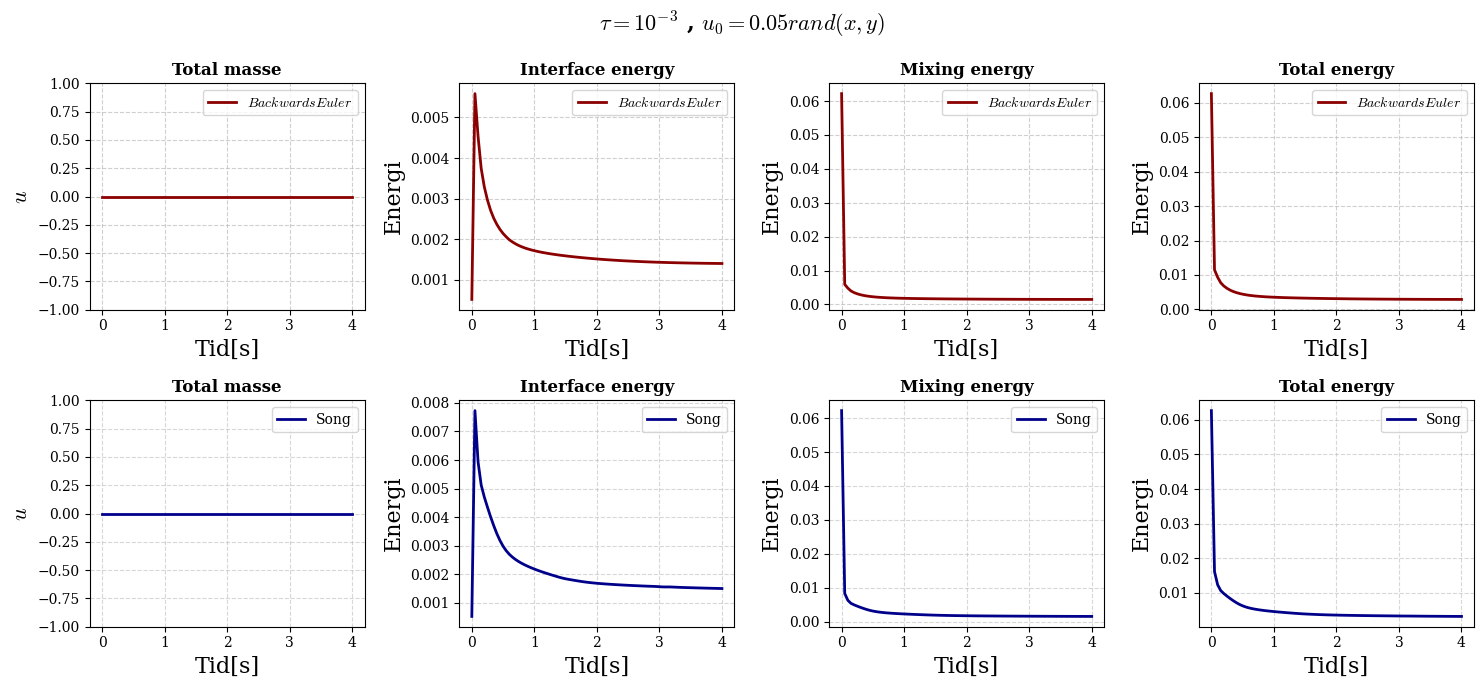

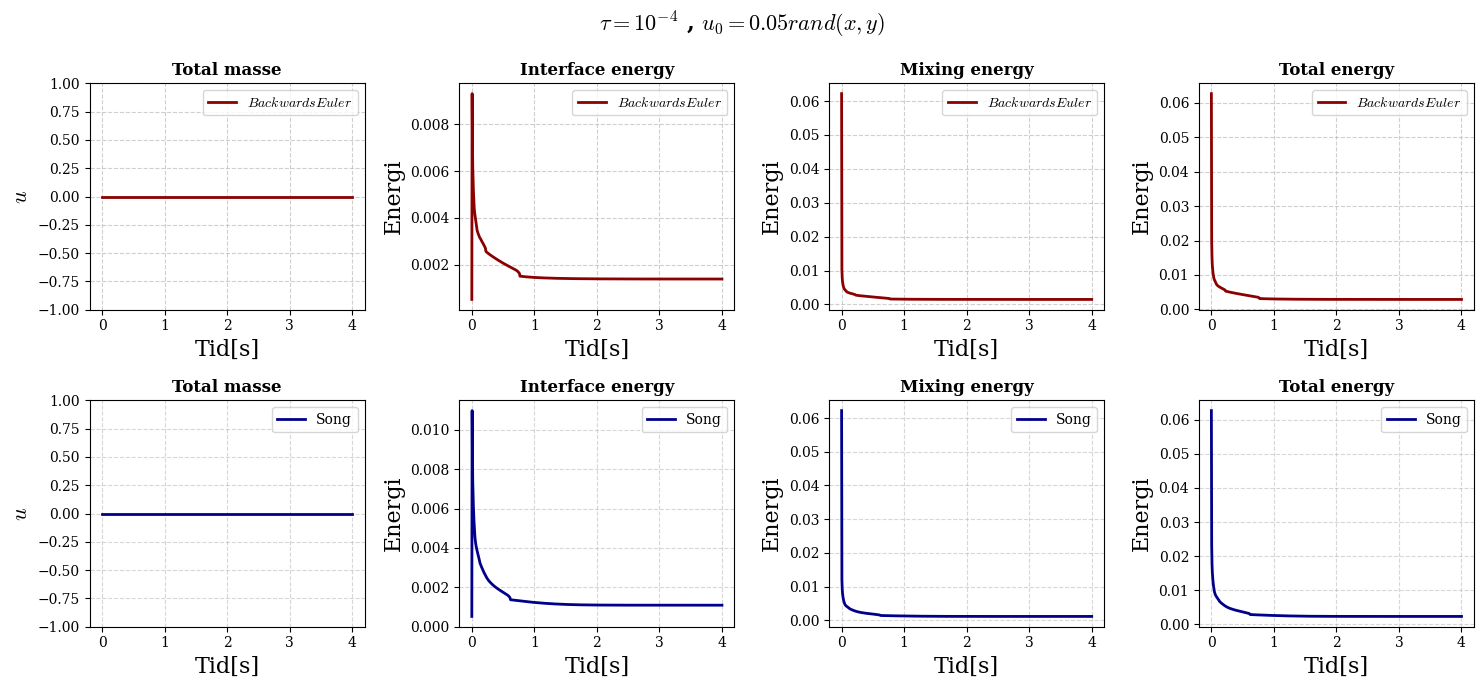

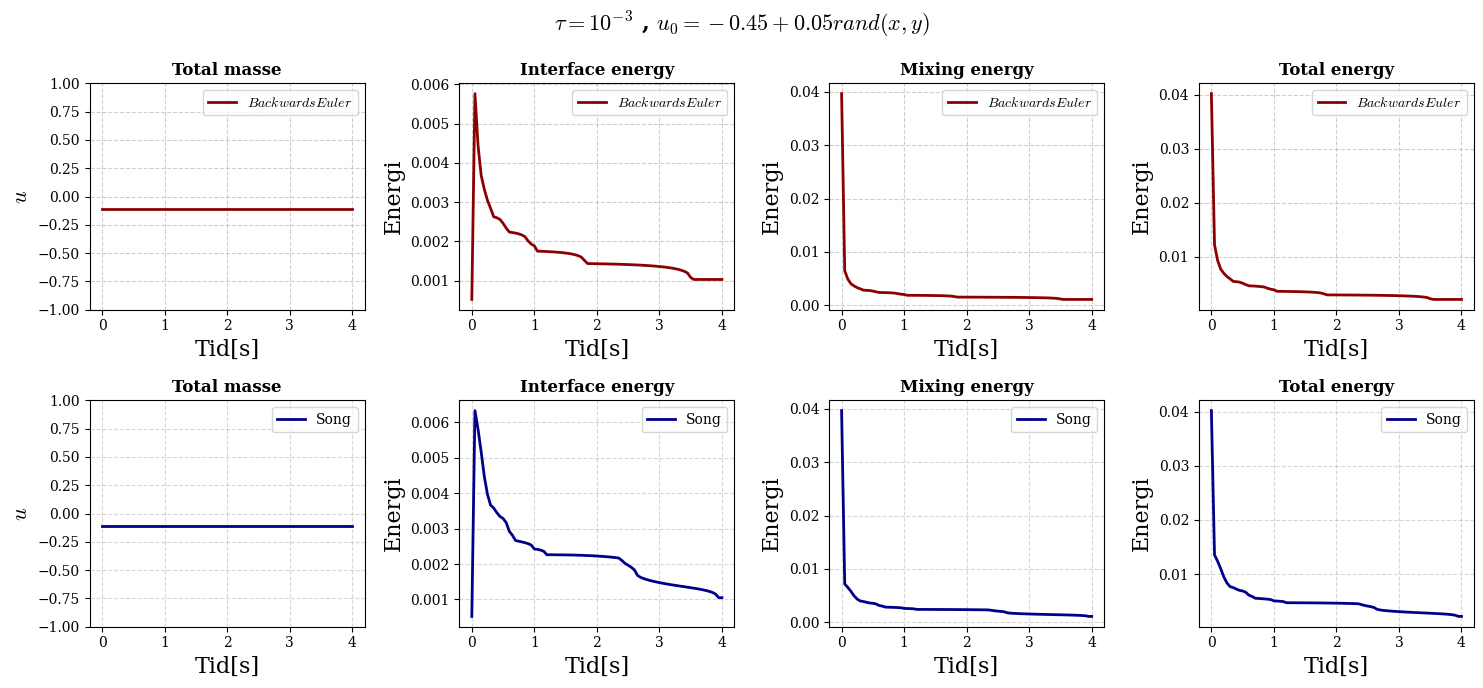

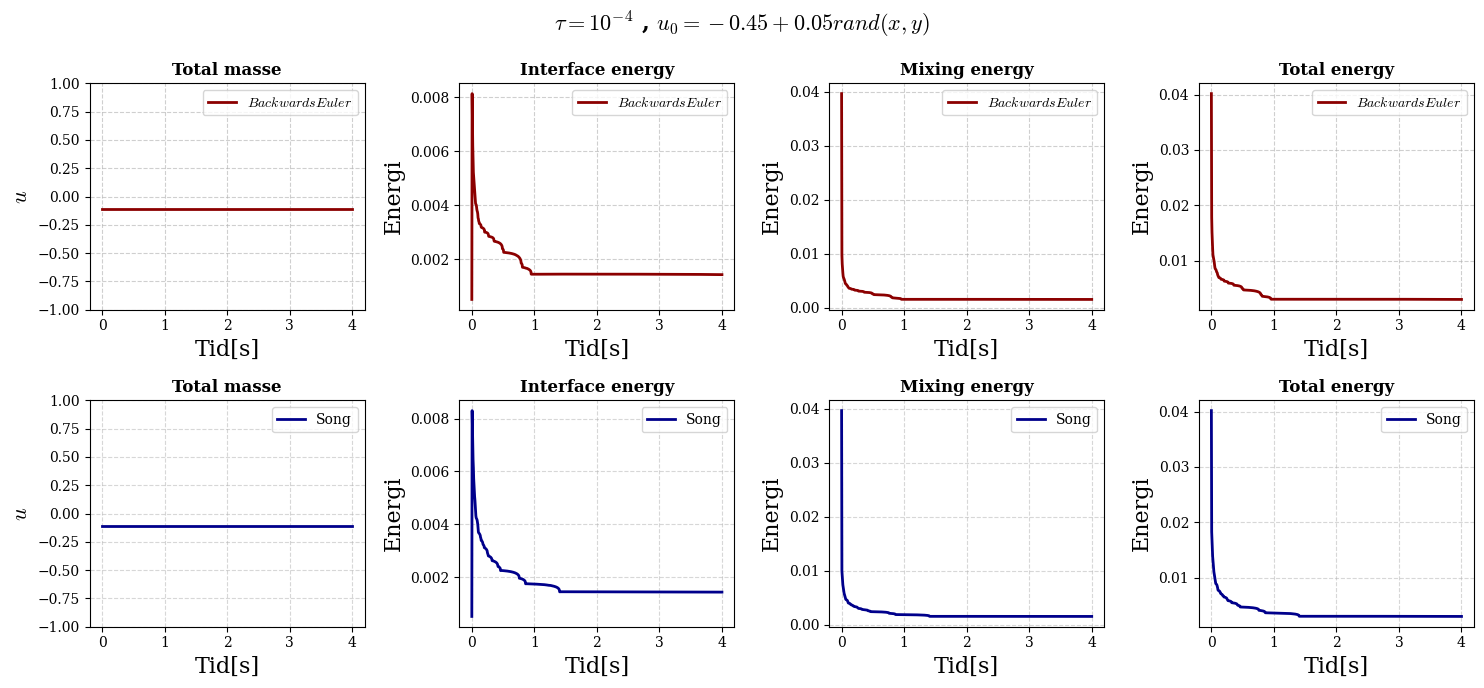

In [170]:
#plotter resultater

plot_6(sol1_vals1, sol1_time1,sol2_vals1,sol2_time1, kappa=kappa, overskrift=r"$\tau = 10^{-3}$ , $u_0 = 0.05rand(x,y)$", type="løser")
plot_6(sol1_vals2, sol1_time2,sol2_vals2,sol2_time2, kappa=kappa, overskrift=r"$\tau = 10^{-4}$ , $u_0 = 0.05rand(x,y)$", type="løser")
plot_6(sol1_vals3, sol1_time3,sol2_vals3,sol2_time3, kappa=kappa, overskrift=r"$\tau = 10^{-3}$ , $u_0 = -0.45 + 0.05rand(x,y)$", type="løser")
plot_6(sol1_vals4, sol1_time4,sol2_vals4,sol2_time4, kappa=kappa, overskrift=r"$\tau = 10^{-4}$ , $u_0 = -0.45 + 0.05rand(x,y)$", type="løser")

In [118]:
#sammenligner den beste løseren for begge tidsintervallene og begge initialbetingelsene

RK_u0T1 = cahn_hilliard_RK(kappa=kappa,X=X,Y=Y,U0=U01,t0=t0,T=T1,Nt=Nt,alpha=alpha,parameterlist=parameterlist1,g = None,tau = tau2)
RK_u1T1 = cahn_hilliard_RK(kappa=kappa,X=X,Y=Y,U0=U02,t0=t0,T=T1,Nt=Nt,alpha=alpha,parameterlist=parameterlist1,g = None,tau = tau2)
RK_u0T2 = cahn_hilliard_RK(kappa=kappa,X=X,Y=Y,U0=U01,t0=t0,T=T2,Nt=Nt,alpha=alpha,parameterlist=parameterlist1,g = None,tau = tau2)
RK_u1T2 = cahn_hilliard_RK(kappa=kappa,X=X,Y=Y,U0=U02,t0=t0,T=T2,Nt=Nt,alpha=alpha,parameterlist=parameterlist1,g = None,tau = tau2)

In [119]:
#lage løsninger for begge tidsintervallene:

sol1_vals1, sol1_time1,sol2_vals1,sol2_time1 = make_solutions(RK_u0T1,RK_u1T1,ctrl = 50)
sol1_vals2, sol1_time2,sol2_vals2,sol2_time2 = make_solutions(RK_u0T2,RK_u1T2,ctrl = 2)

100%|██████████| 4.000000000004016/4 [08:08<00:00, 122.13s/it]    
100%|██████████| 4.000000000004016/4 [07:44<00:00, 116.19s/it]    
100%|█████████▉| 0.009999999999999995/0.01 [00:01<00:00, 120.60s/it] 
100%|█████████▉| 0.009999999999999995/0.01 [00:01<00:00, 128.17s/it] 


### *Sammenlikning av starttilstander ved ulike tidsintervall*

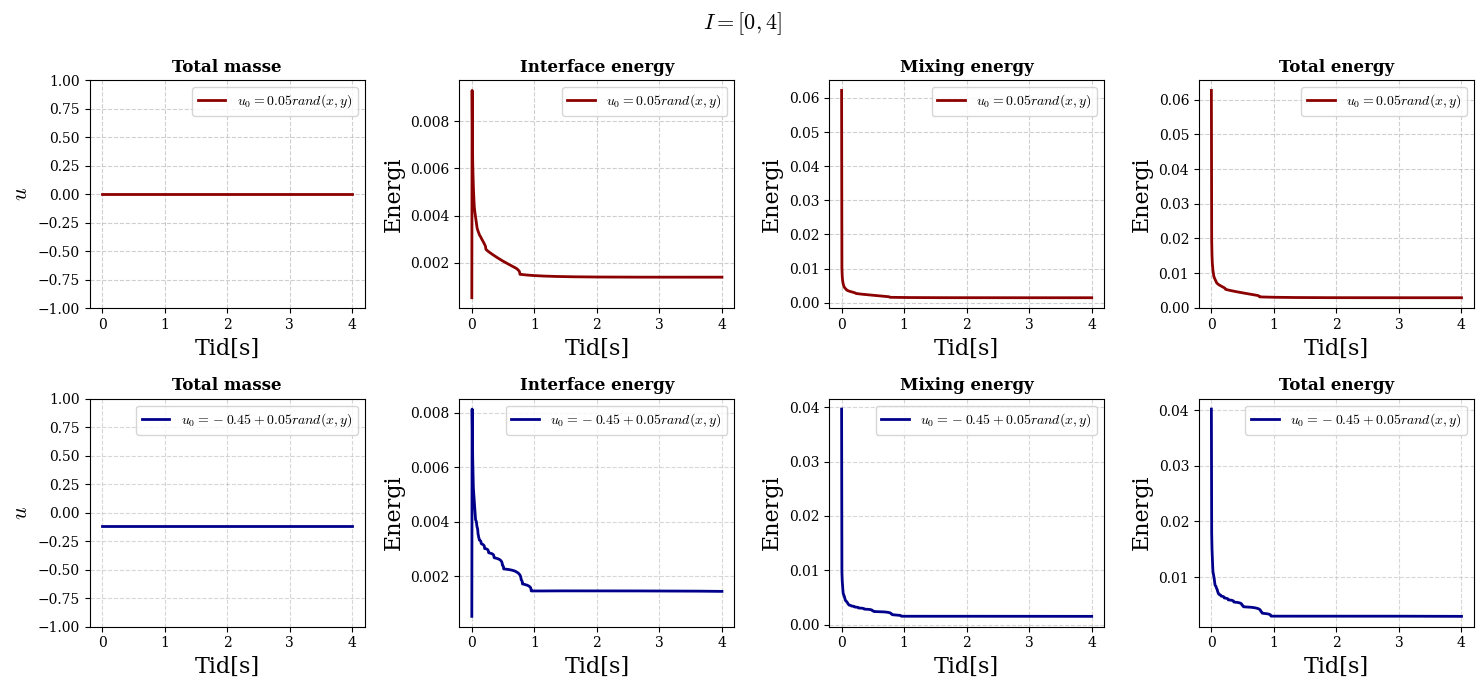

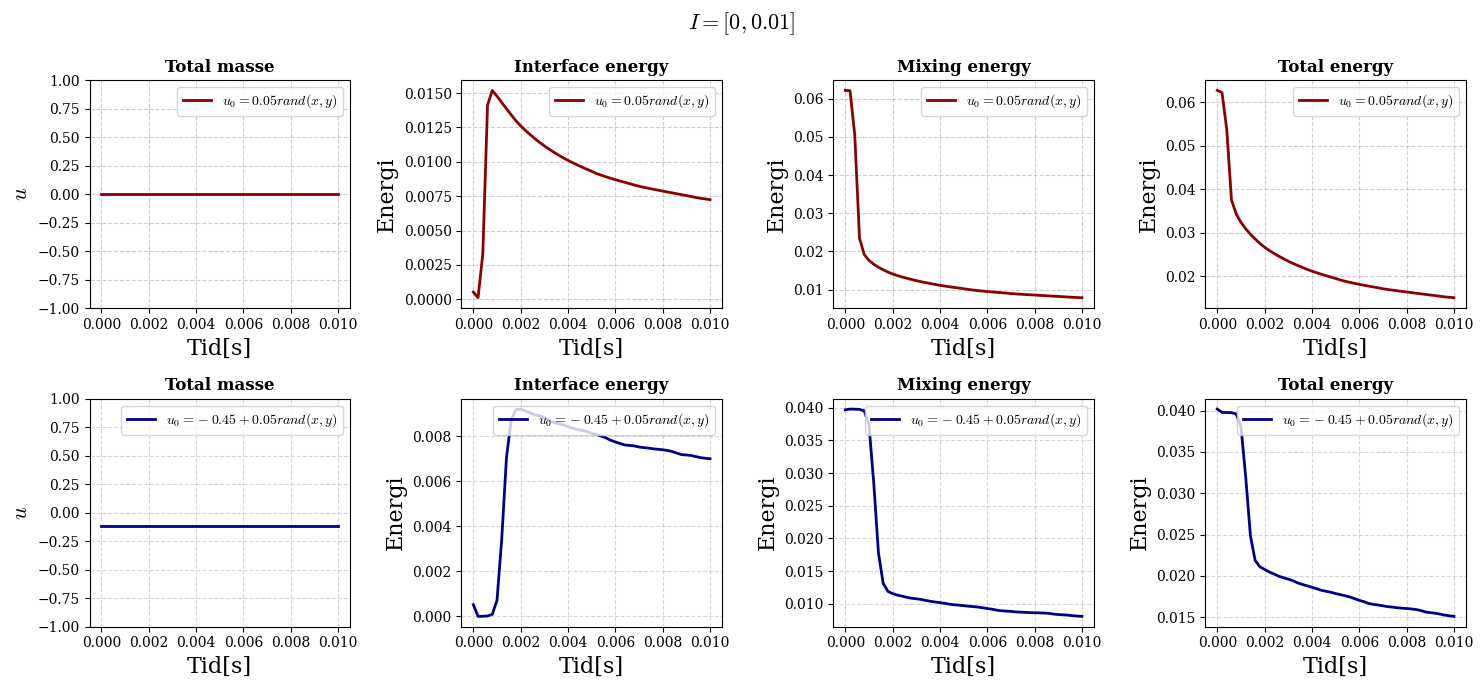

In [160]:
#plott

plot_6(sol1_vals1, sol1_time1,sol2_vals1,sol2_time1, kappa=kappa, overskrift=r"$I = [0, 4]$", type= "initial")
plot_6(sol1_vals2, sol1_time2,sol2_vals2,sol2_time2, kappa=kappa, overskrift=r"$I = [0, 0.01]$", type = "initial")

### *Diskusjon:*


*Total masse:*  

Vi observerer fra plottet at den totale massen holdes konstant, uavhenig av løsningsmetode eller initialbetingelser, dette forventer vi fra teoridelen som vi gikk gjennom i oppgave 1.

*Interface energy:*  

Vi observerer at interface-energien synker over tid. Denne størrelsen representerer energien knyttet til grenseflatene mellom de to fasene, og er direkte relatert til størrelsen på gradientene i løsningen. I starten er løsningen homogent blandet, noe som gir små eller ubetydelige gradienter – og dermed lav interface-energi. Etter hvert som fasene begynner å separere, dannes skarpe overganger, som fører til store gradienter. Dette forklarer den tydelige toppen i interface-energien tidlig i simuleringen. Etter hvert som systemet modnes og fasene separeres fullstendig, jevner grenseflatene seg ut, gradientene minker og interface-energien faller tilsvarende. 


*Mixing energy:*  

Mixing-energien starter på et høyt nivå og synker gradvis før den stabiliserer seg. Denne komponenten reflekterer graden av blanding i systemet – høy når stoffene er godt blandet, og lav når de er klart separerte. Den observerte nedgangen i mixing-energi viser altså at blandingen minker over tid, i tråd med forventet faseseparasjon.

*Total energy:*  

Til slutt ser vi at totalenergien synker monotonisk. Dette er i samsvar med teorien for Cahn–Hilliard-ligningen, hvor systemet kan tolkes som en gradientflyt som minimerer den totale frie energien. Den totale energien består av summen av interface- og mixing-energi, og det at den kontinuerlig synker viser at systemet utvikler seg mot en lavenergitilstand, slik vi forventer for en diffusjonsdrevet separasjonsprosess.

*Energiutvikling for initialverdiene:*

La $u_1 = 0.05rand(x,y)$ og $u_2 = -0.45 + 0.05rand(x,y)$  

For $u_1$ går interface energien opp raskt (etter 0.001 s) mens for $u_2$ så øker inteface energien litt saktere (etter 0.002). Dette viser at når vi har like mye av hvert stoff så skilles stoffene raskere enn der vi har mer av det ene stoffet. Dette sier noe om hvor lenge spinodal decomposition varer (vi kommer tilbake til dette senere). Dette gjør at den totale energien går saktere ned for den første initialbetingelsen, som vi kan se i plottene. Vi kan også se i animasjonene at spinodal dekomposition varer lengre for $u_2$ enn $u_1$

*Tidsstegslengde og utvikling:*

Fra plottene ser vi at ved å bruke $\tau = 10^{-4}$ så går den totale energien raskere ned (vi oppnår likevekt raskere i simuleringen) enn ved å bruke $\tau = 10^{-3}$. Dette vil påvirke hvilket tidsintervall vi må kjøre den endelige simuleringen på.

*Løservalg:*

Observerer at vi oppnår likevekt raskere med løseren fra oppgave 5 enn med løseren fra oppgave 4. 

*Spinodal vs. Ostwald ripening:*

Fra plottene med tidsintervall $I = [0, 0.01]$ ser det ut som at spinodal dekomposisjon varer fra start til rundt $t = 0.001$ for $u_2$ og rundt $t = 0.002$ for $u_1$, da grenseflateenergien stiger og blandingsenergien synker i dette intervallet. For Ostwald modning ser vi på plottene med tidsintervall $I = [0, 4]$, da alle energiene fortsetter å synke frem til omtrent $t = 0.8$ for $u_2$ og $t=1$ for $u_1$ med $\tau = 10^{-4}$. Etter dette har systemet oppnått tilnærmet likevekt ($t = 1s$). Hvor lang tid det tar å oppnå likevekt avhenger av hvor stort tidssteget er. Vi velger $T = 5$ i simuleringen slik at vi er sikker på å oppnå likevektsstilstand som sluttilstand.


In [134]:
#final simulation for the cahn-hilliard equation RK u1:
Td = 5
n = 40000
tau = Td/n

RK_cahn_hilliard1 = cahn_hilliard_RK(kappa=kappa,X=X,Y=Y,U0=U02,t0=t0,T=Td,Nt=Nt,alpha=alpha,parameterlist=parameterlist1,g = None,tau = tau)

ctr = 0
RKCH1_real = []
RKCH1_time = []
ctr_list = [0,1,4,6,10,20,100,500,1000,5000,10000,20000,39999]


for u,t in RK_cahn_hilliard1:
    if ctr in ctr_list:
        real_vals = ifft2(u).real
        RKCH1_real.append(real_vals)
        RKCH1_time.append(t)
    ctr += 1


100%|█████████▉| 4.999999999999685/5 [07:39<00:00, 91.85s/it]    


In [135]:
#final simulation for the cahn-hilliard equation RK u2:
Td = 5
n = 40000
tau = Td/n

RK_cahn_hilliard1 = cahn_hilliard_RK(kappa=kappa,X=X,Y=Y,U0=U01,t0=t0,T=Td,Nt=Nt,alpha=alpha,parameterlist=parameterlist1,g = None,tau = tau)

ctr = 0
RKCH2_real = []
RKCH2_time = []
ctr_list = [0,1,4,6,10,20,100,500,1000,5000,10000,20000,39999]


for u,t in RK_cahn_hilliard1:
    if ctr in ctr_list:
        real_vals = ifft2(u).real
        RKCH2_real.append(real_vals)
        RKCH2_time.append(t)
    ctr += 1

100%|█████████▉| 4.999999999999685/5 [07:44<00:00, 92.84s/it]    


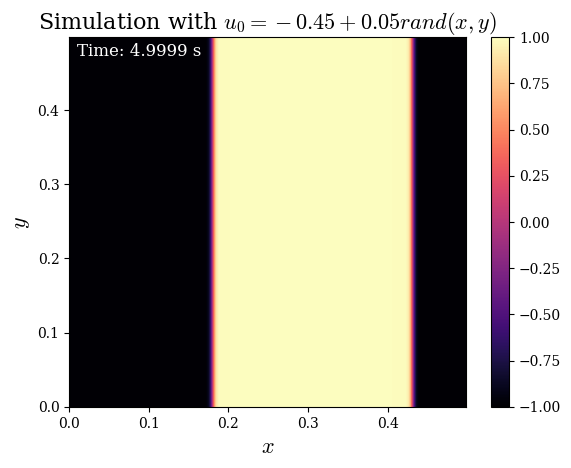

In [143]:

fig, ax = plt.subplots()
contour = ax.contourf(X, Y, RKCH2_real[0], levels=100, cmap='magma', vmin=-1, vmax=1)

sm = plt.cm.ScalarMappable(cmap='magma')
sm.set_array([])  
sm.set_clim(-1, 1)
cbar = fig.colorbar(sm, ax=ax)
ax.set_title(r"Simulation with $u_0 = -0.45 + 0.05rand(x,y)$")
ax.grid(False)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
frame_text = ax.text(0.02, 0.95, "", transform=ax.transAxes, color='white')

def update(i):
    global contour
    for coll in contour.collections:
        coll.remove()
    contour = ax.contourf(X, Y, RKCH2_real[i], levels=100, cmap='magma', vmin=-1, vmax=1)
    frame_text.set_text(f"Time: {np.round(RKCH2_time[i],4)} s")
    return contour.collections + [frame_text]

ani = FuncAnimation(fig, update, frames=len(RKCH2_real), interval=30)
ani.save('CahnHilliard_RK_u1.gif', writer=PillowWriter(fps=1))
plt.show()

#### Kommentar til animasjon:

Vi ser at animasjonene stemmer godt overens med drøftingen ovenfor.